# Model for Retargeting Strategy

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option("display.max_columns", None)

# cluster models
from clusteval import clusteval

In [2]:
df_numdata = pd.read_csv("omya/sources/numericdata.csv")
df_catdata = pd.read_csv("omya/sources/categoricaldata.csv")
df = pd.read_csv("omya/sources/model_data.csv")
df.head(3)

customer  sales_qty_2021  sales_qty_2022  sales_qty_2023  \
0  Customer_1005        28682071        32079526        31453752   
1  Customer_1011        26662722        26804515        28793437   
2  Customer_1023        18573979        25156206        26389512   

   sales_qty_2024  net_sales_2021  net_sales_2022  net_sales_2023  \
0        26429101    1.695876e+09    1.833924e+09    1.900422e+09   
1        24591574    1.362151e+09    1.531981e+09    1.890697e+09   
2        29153877    1.089888e+09    1.478579e+09    1.669236e+09   

   net_sales_2024       p2_2021       p2_2022       p2_2023       p2_2024  \
0    1.595169e+09  9.462729e+08  8.847213e+08  1.072850e+09  7.123357e+08   
1    1.581387e+09  5.740576e+08  7.805375e+08  1.046884e+09  7.476680e+08   
2    1.651936e+09  5.051393e+08  8.404226e+08  6.137710e+08  8.069199e+08   

   qty_2021_score  qty_2022_score  qty_2023_score  qty_2024_score  \
0               3               4               4               2   
1               2               2               3               1   
2               1               2               2               3   

   sales_2021_score  sales_2022_score  sales_2023_score  sales_2024_score  \
0               3.0               4.0               4.0               2.0   
1               1.0               2.0               4.0               2.0   
2               1.0               2.0               3.0               2.0   

   p2_2021_score  p2_2022_score  p2_2023_score  p2_2024_score  \
0            4.0            3.0            5.0            1.0   
1            1.0            2.0            4.0            2.0   
2            1.0            3.0            1.0            2.0   

  qty_2021_score_desc qty_2022_score_desc qty_2023_score_desc  \
0              Medium                High                High   
1                 Low                 Low              Medium   
2         Neglectable                 Low                 Low   

  qty_2024_score_desc sales_2021_score_desc sales_2022_score_desc  \
0                 Low                Medium                  High   
1         Neglectable           Neglectable                   Low   
2              Medium           Neglectable                   Low   

  sales_2023_score_desc sales_2024_score_desc p2_2021_score_desc  \
0                  High                   Low               High   
1                  High                   Low        Neglectable   
2                Medium                   Low        Neglectable   

  p2_2022_score_desc p2_2023_score_desc p2_2024_score_desc  \
0             Medium          Strategic        Neglectable   
1                Low               High                Low   
2             Medium        Neglectable                Low   

   material_portfolio                     material_portfolio_desc  \
0                   4  MAT000810, MAT002520, MAT000318, MAT000834   
1                   4  MAT000256, MAT000812, MAT001174, MAT000449   
2                   4  MAT001921, MAT002068, MAT002926, MAT001675   

   brand_portfolio                            brand_portfolio_desc  \
0                4  Brand_2805, Brand_5892, Brand_3658, Brand_5729   
1                4    Brand_396, Brand_6463, Brand_707, Brand_1399   
2                4  Brand_7539, Brand_7706, Brand_2936, Brand_5802   

   product_type_portfolio                        product_type_portfolio_desc  \
0                       4  Product_Type_1283, Product_Type_317, Product_T...   
1                       4  Product_Type_676, Product_Type_1252, Product_T...   
2                       4  Product_Type_649, Product_Type_776, Product_Ty...   

   material_portfolio_score  brand_portfolio_score  \
0                         2                      2   
1                         2                      2   
2                         2                      2   

   product_type_portfolio_score material_portfolio_score_desc  \
0                             2                       several   
1               

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer                           926 non-null    object 
 1   sales_qty_2021                     926 non-null    int64  
 2   sales_qty_2022                     926 non-null    int64  
 3   sales_qty_2023                     926 non-null    int64  
 4   sales_qty_2024                     926 non-null    int64  
 5   net_sales_2021                     926 non-null    float64
 6   net_sales_2022                     926 non-null    float64
 7   net_sales_2023                     926 non-null    float64
 8   net_sales_2024                     926 non-null    float64
 9   p2_2021                            926 non-null    float64
 10  p2_2022                            926 non-null    float64
 11  p2_2023                            926 non-null    float64

## Preprocessing

Se opta por las siguientes ponderaciones sobre las distintas calificaciones:


|**Current Business (0.5)**| **Potential (0.5)**    |
-----------------------------------------------------
|qty 2021: 0.02            |sales 2021:   0.02      |
|qty 2022: 0.02            |sales 2022:   0.02      |
|qty 2023: 0.04            |sales 2023:   0.06      |
|qty 2024: 0.1             |sales 2024:   0.2       |
|material: 0.06            |relationship: 0.08      |
|brand:    0.05            |mkt position: 0.05      |
|product:  0.05            |p 2021:       0.01      |
|f_t null: 0.02            |p 2022:       0.01      |
|f_t Q1:   0.035           |p 2023:       0.02      |
|f_t Q2:   0.035           |p 2024:       0.03      |
|f_t Q3:   0.035           |                        |
|f_t Q4:   0.035           |                        |


### Ponderaciones

In [4]:
#df.columns

In [5]:
score_cols = ['qty_2021_score', 'qty_2022_score', 'qty_2023_score', 'qty_2024_score', # 0 - 3
              'sales_2021_score', 'sales_2022_score', 'sales_2023_score', 'sales_2024_score', # 4 - 7
              'material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score', # 8 - 10
              'feature_tag_null_score', 'feature_tag_q1_score', 'feature_tag_q2_score', 'feature_tag_q3_score', 'feature_tag_q4_score', # 11 - 15
              'relationship_score', 'market_position_score', # 16 - 17
              'p2_2021_score', 'p2_2022_score', 'p2_2023_score','p2_2024_score'] # 18 -21

In [6]:
df_w = pd.DataFrame({
    'customer'      :   df['customer'],
    score_cols[0]   :   df[score_cols[0]].apply(lambda x: x*0.02),
    score_cols[1]   :   df[score_cols[1]].apply(lambda x: x*0.02),
    score_cols[2]   :   df[score_cols[2]].apply(lambda x: x*0.04),
    score_cols[3]   :   df[score_cols[3]].apply(lambda x: x*0.1),
    score_cols[4]   :   df[score_cols[4]].apply(lambda x: x*0.02),
    score_cols[5]   :   df[score_cols[5]].apply(lambda x: x*0.02),
    score_cols[6]   :   df[score_cols[6]].apply(lambda x: x*0.06),
    score_cols[7]   :   df[score_cols[7]].apply(lambda x: x*0.2),
    score_cols[8]   :   df[score_cols[8]].apply(lambda x: x*0.06),
    score_cols[9]   :   df[score_cols[9]].apply(lambda x: x*0.05),
    score_cols[10]   :   df[score_cols[10]].apply(lambda x: x*0.05),
    score_cols[11]   :   df[score_cols[11]].apply(lambda x: x*0.02),
    score_cols[12]   :   df[score_cols[12]].apply(lambda x: x*0.035),
    score_cols[13]   :   df[score_cols[13]].apply(lambda x: x*0.035),
    score_cols[14]   :   df[score_cols[14]].apply(lambda x: x*0.035),
    score_cols[15]   :   df[score_cols[15]].apply(lambda x: x*0.035),
    score_cols[16]   :   df[score_cols[16]].apply(lambda x: x*0.08),
    score_cols[17]   :   df[score_cols[17]].apply(lambda x: x*0.05),
    score_cols[18]   :   df[score_cols[18]].apply(lambda x: x*0.01),
    score_cols[19]   :   df[score_cols[19]].apply(lambda x: x*0.01),
    score_cols[20]   :   df[score_cols[20]].apply(lambda x: x*0.02),
    score_cols[21]   :   df[score_cols[21]].apply(lambda x: x*0.03)
})

for column in df_w[score_cols].columns:
    df[column] = df[column].astype(int)
df_w.head(5)

customer  qty_2021_score  qty_2022_score  qty_2023_score  \
0  Customer_1005            0.06            0.08            0.16   
1  Customer_1011            0.04            0.04            0.12   
2  Customer_1023            0.02            0.04            0.08   
3  Customer_1039            0.02            0.02            0.04   
4  Customer_1048            0.06            0.08            0.16   

   qty_2024_score  sales_2021_score  sales_2022_score  sales_2023_score  \
0             0.2              0.06              0.08              0.24   
1             0.1              0.02              0.04              0.24   
2             0.3              0.02              0.04              0.18   
3             0.3              0.02              0.02              0.06   
4             0.2              0.04              0.08              0.12   

   sales_2024_score  material_portfolio_score  brand_portfolio_score  \
0               0.4                      0.12                    0.1   
1               0.4                      0.12                    0.1   
2               0.4                      0.12                    0.1   
3               0.6                      0.12                    0.1   
4               0.4                      0.12                    0.1   

   product_type_portfolio_score  feature_tag_null_score  feature_tag_q1_score  \
0                           0.1                    0.02                 0.105   
1                           0.1                    0.04                 0.105   
2                           0.1                    0.04                 0.035   
3                           0.1                    0.02                 0.035   
4                           0.1                    0.08                 0.105   

   feature_tag_q2_score  feature_tag_q3_score  feature_tag_q4_score  \
0                 0.035                 0.070                 0.035   
1                 0.035                 0.105                 0.035   
2                 0.070                 0.035                 0.035   
3                 0.070                 0.070                 0.035   
4                 0.035                 0.070                 0.035   

   relationship_score  market_position_score  p2_2021_score  p2_2022_score  \
0                0.40                   0.05           0.04           0.03   
1                0.24                   0.10           0.01           0.02   
2                0.24                   0.05           0.01           0.03   
3                0.24                   0.10           0.01           0.01   
4                0.40                   0.25           0.03           0.05   

   p2_2023_score  p2_2024_score  
0           0.10           0.03  
1           0.08           0.06  
2           0.02           0.06  
3           0.04           0.09  
4           0.08           0.06

### Columnas de calificacion ponderada (Current Business, Potential)

In [7]:
l_current_business = ['qty_2021_score', 'qty_2022_score', 'qty_2023_score', 'qty_2024_score',
                      'material_portfolio_score', 'brand_portfolio_score', 'product_type_portfolio_score',
                      'feature_tag_null_score', 'feature_tag_q1_score', 'feature_tag_q2_score', 'feature_tag_q3_score', 'feature_tag_q4_score']
l_potential = ['sales_2021_score', 'sales_2022_score', 'sales_2023_score', 'sales_2024_score',
               'relationship_score', 'market_position_score',
               'p2_2021_score', 'p2_2022_score', 'p2_2023_score','p2_2024_score']

In [8]:
# se agregan a df
df['current_business'] = df_w[l_current_business].sum(axis=1)*2
df['potential'] = df_w[l_potential].sum(axis=1)*2

df[['customer','current_business', 'potential']].head(3)

customer  current_business  potential
0  Customer_1005              2.17       2.86
1  Customer_1011              1.88       2.42
2  Customer_1023              1.95       2.10

In [9]:
df[['current_business', 'potential']].describe()

current_business   potential
count        926.000000  926.000000
mean           2.279698    2.964600
std            0.547537    0.947875
min            1.320000    1.100000
25%            1.872500    2.200000
50%            2.210000    2.920000
75%            2.580000    3.720000
max            3.880000    5.000000

In [10]:
#df[df['current_business'] >= 3]

### Datos para clasificacion

Se tomaran solo los datos resultados de la ponderacion

In [11]:
X = df[['current_business', 'potential']].copy()

## Clustering models

### Revision de parametros de clustering

#### Parametros de K Means y Silhouette basados en el metodo derivativo

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 5
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [5].
[clusteval] >INFO> Fin.


[2 2 2 2 4 4 2 2 2 5 2 4 5 5 4 5 2 1 4 1 1 2 5 4 2 2 4 5 5 4 2 4 2 2 4 4 5
 4 1 5 5 2 5 4 5 4 2 4 5 2 5 2 3 2 5 5 5 4 2 2 2 2 2 5 5 5 2 4 4 4 2 4 5 4
 4 1 1 2 2 1 5 5 2 4 2 5 2 5 2 2 4 2 2 2 2 1 1 5 2 4 4 5 4 2 2 2 4 2 4 2 1
 5 4 4 4 4 2 4 5 1 2 3 1 2 2 2 1 2 5 2 4 4 2 1 2 1 2 4 4 4 4 2 1 3 2 5 1 2
 2 4 4 1 3 4 3 4 4 2 5 1 2 4 5 3 2 2 5 2 4 5 5 2 1 2 4 4 2 4 5 1 2 2 2 5 3
 4 5 4 1 2 2 5 2 4 4 4 3 1 2 1 4 4 5 3 1 4 1 2 2 5 5 1 2 5 1 4 2 5 4 4 4 2
 2 2 4 4 1 1 1 5 4 4 2 2 2 2 1 2 4 5 5 3 3 2 2 2 4 5 2 5 1 2 5 2 3 2 2 2 5
 2 3 2 4 1 4 1 4 1 4 4 2 1 1 1 5 4 5 2 2 5 2 2 2 4 2 4 4 5 1 5 4 5 4 4 2 3
 2 2 4 2 2 5 1 2 2 3 4 1 2 3 2 2 5 2 1 1 2 2 5 2 2 1 2 2 2 1 2 1 5 5 5 2 1
 2 1 5 5 5 5 2 5 1 2 5 2 2 2 4 5 4 2 4 4 2 4 4 2 1 5 5 5 2 2 4 4 4 2 4 1 2
 2 2 5 1 2 2 5 2 2 2 5 4 4 5 5 5 5 2 4 1 2 4 4 3 1 2 3 3 4 2 5 2 4 5 1 5 4
 4 2 2 3 4 5 4 5 3 1 3 4 5 2 3 4 3 1 4 4 2 2 1 2 2 2 2 3 5 5 5 4 2 4 5 2 5
 2 5 5 2 2 4 3 2 3 1 4 2 2 5 4 4 2 1 3 2 5 1 4 5 3 5 2 2 4 2 3 1 2 1 4 4 2
 5 2 3 5 2 5 3 5 2 3 5 1 

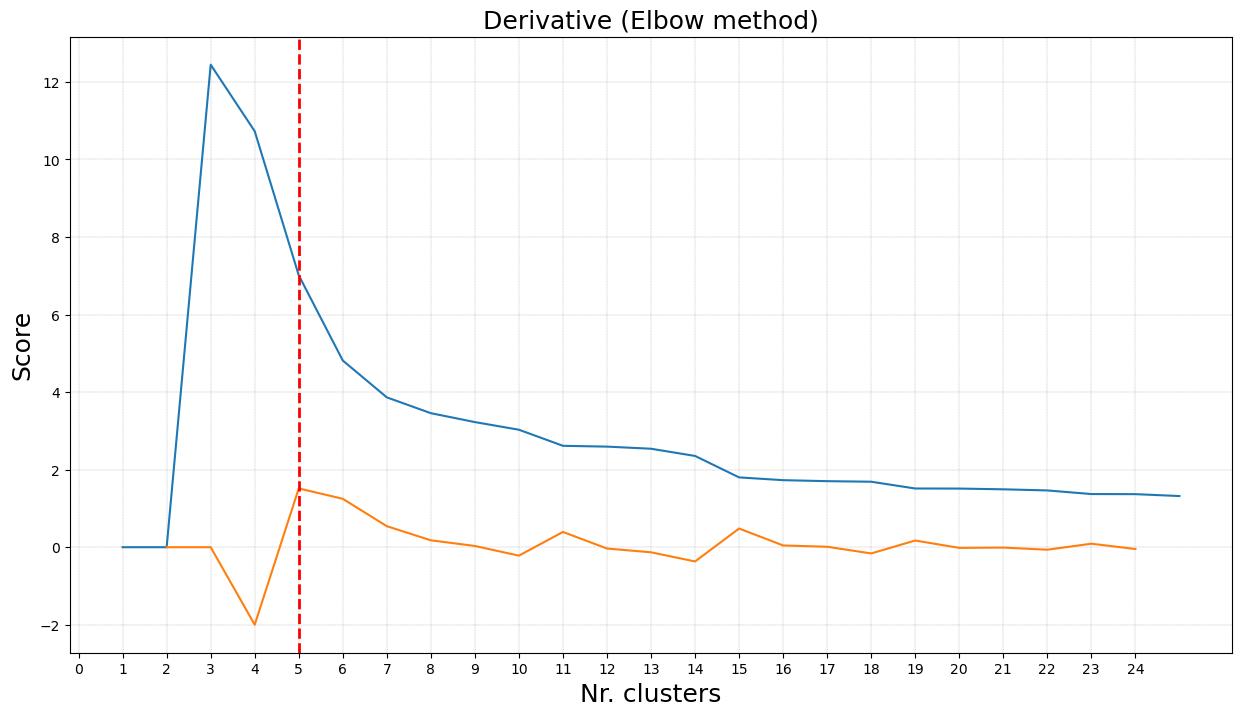

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 5, average silhouette_score=0.419


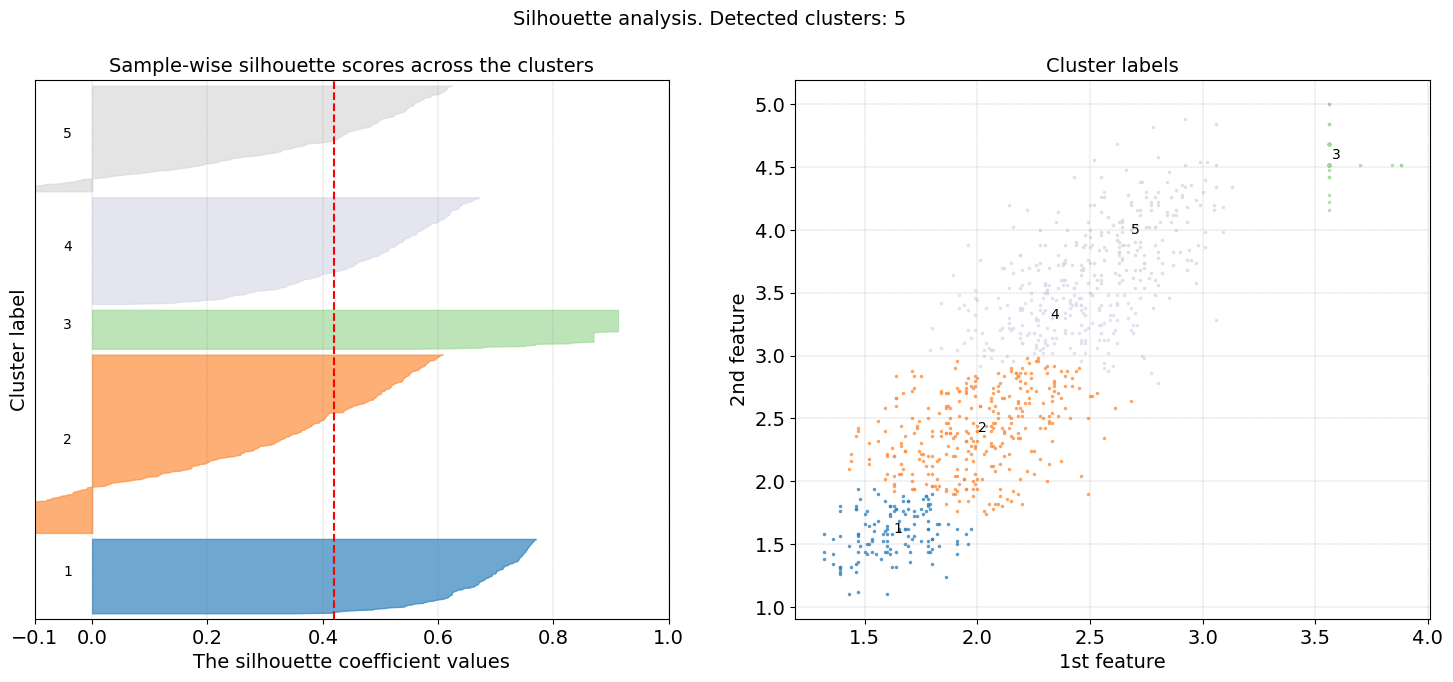

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

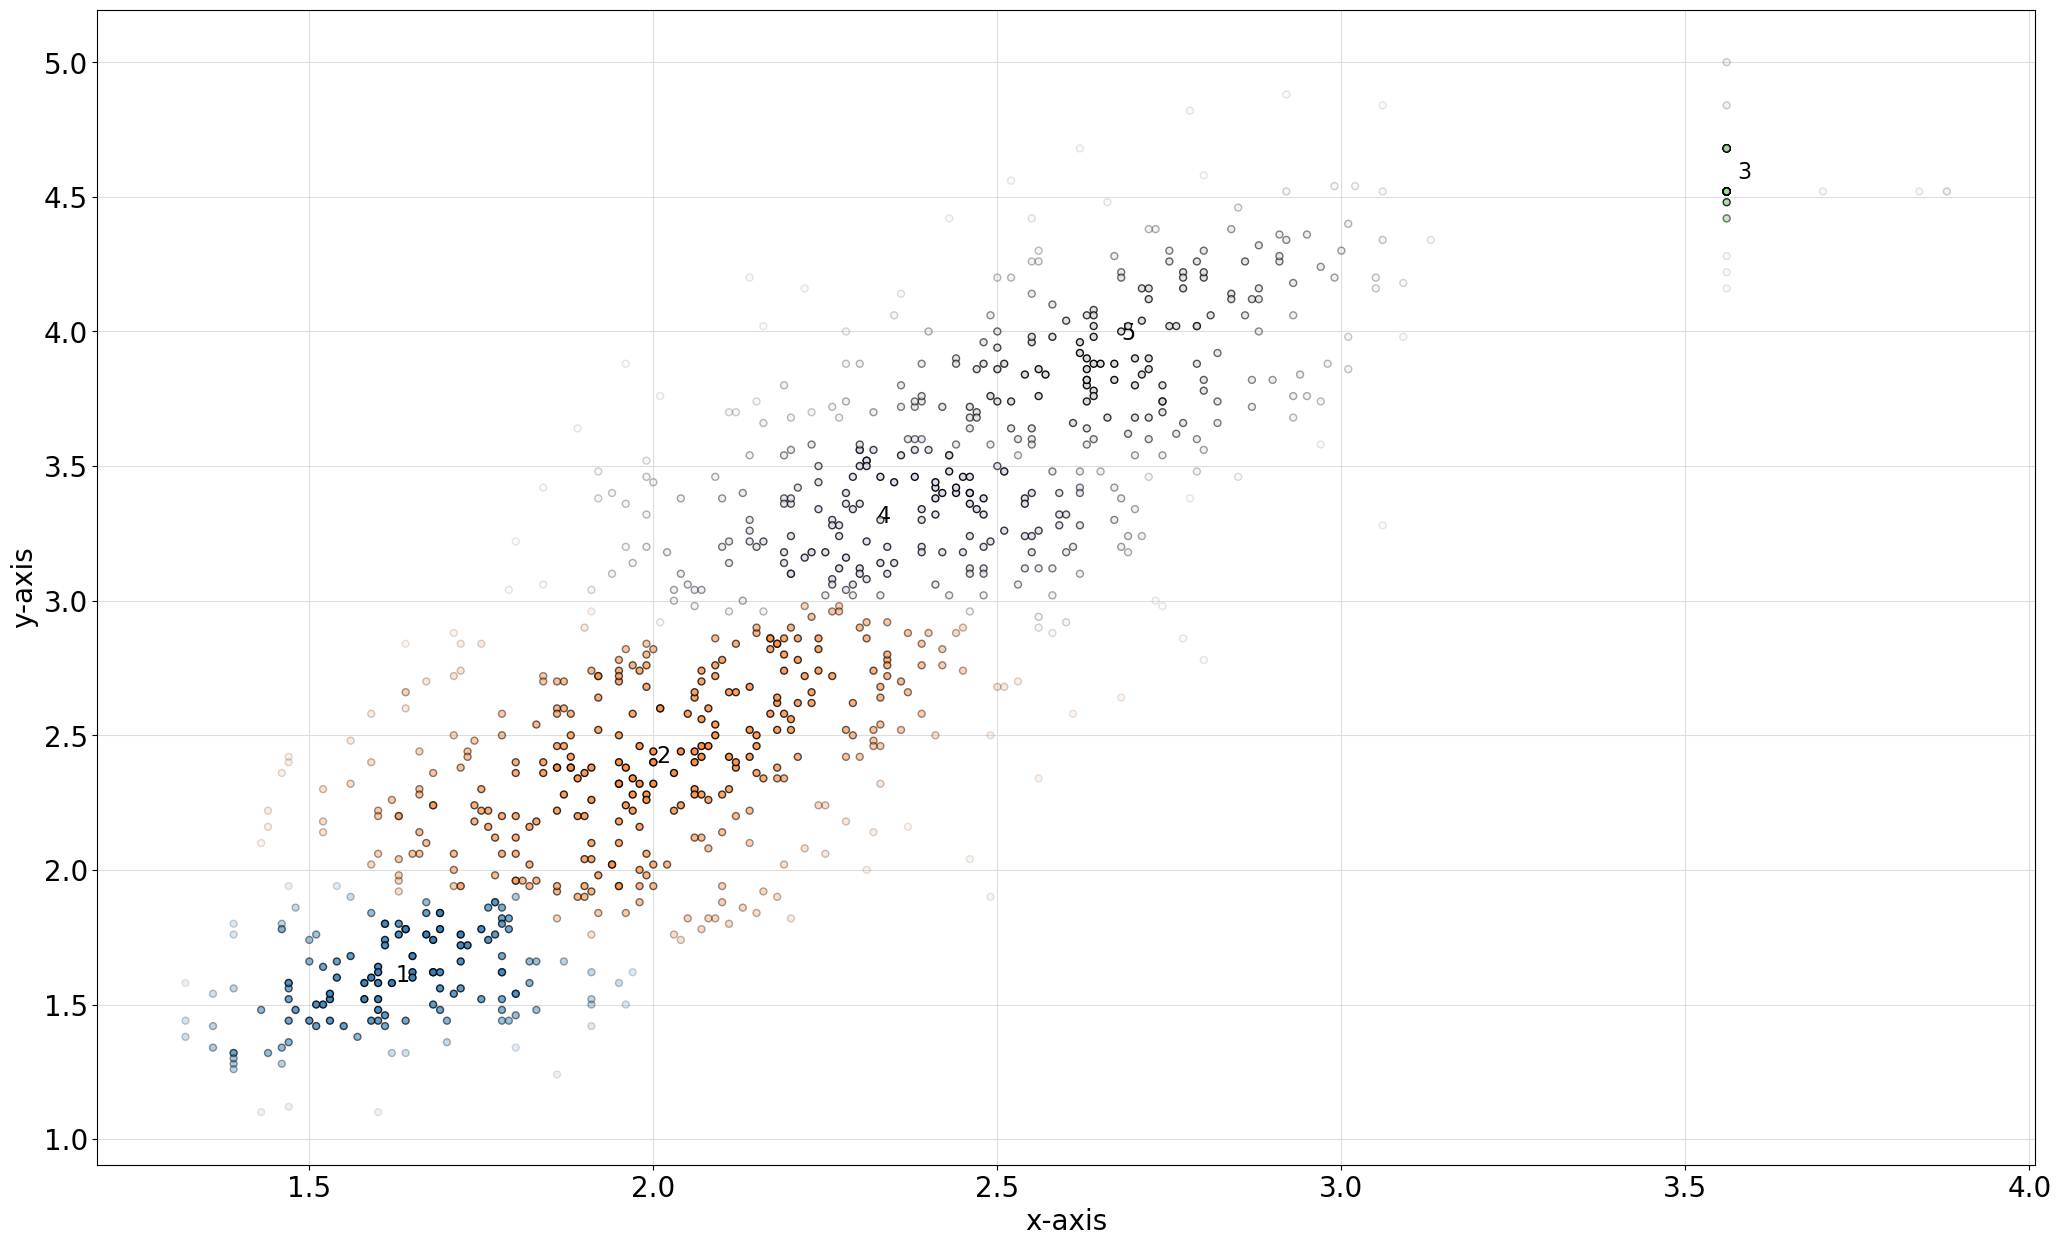

In [12]:
# Intialize model
ce1 = clusteval(cluster='agglomerative', evaluate='derivative')

# Cluster evaluation
results1 = ce1.fit(X)

# The clustering label can be found in:
print(results1['labx'])

# Make plots
ce1.plot()
ce1.plot_silhouette()
ce1.scatter(X)

#### Parametros basados en Silhouette Score

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 62.93it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


[0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1
 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0
 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0
 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1
 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0
 1 0 1 1 0 1 1 1 0 1 1 0 

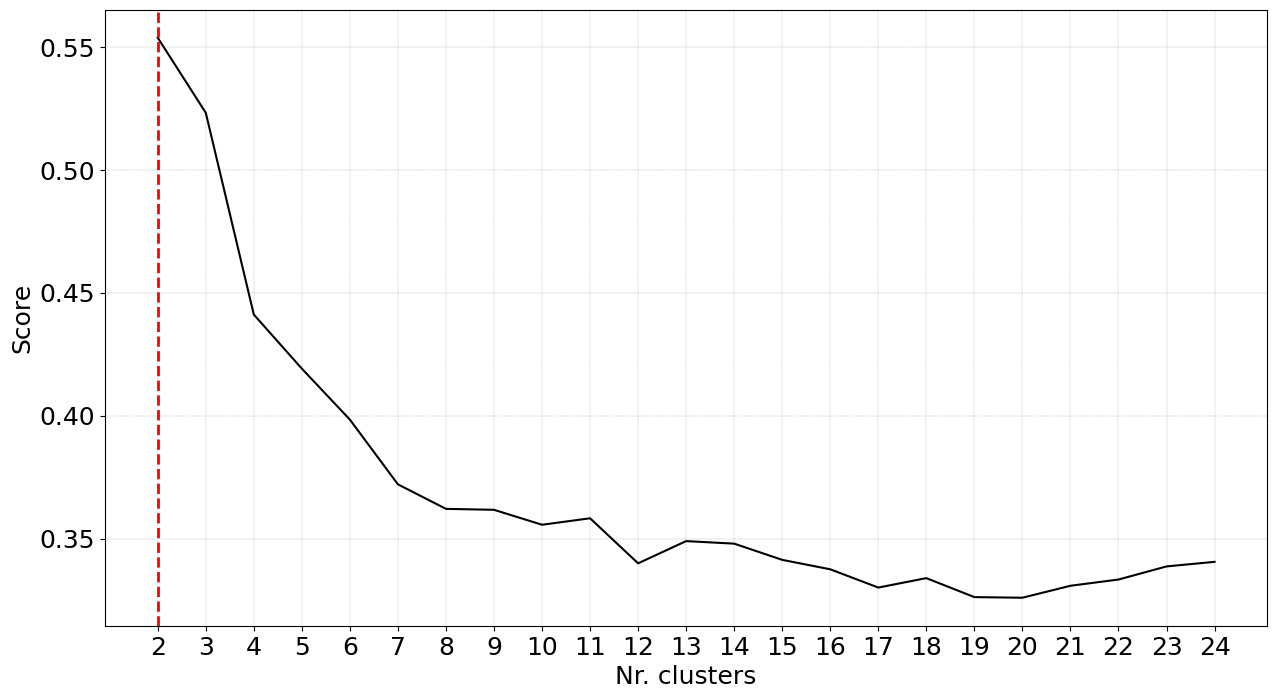

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 2, average silhouette_score=0.554


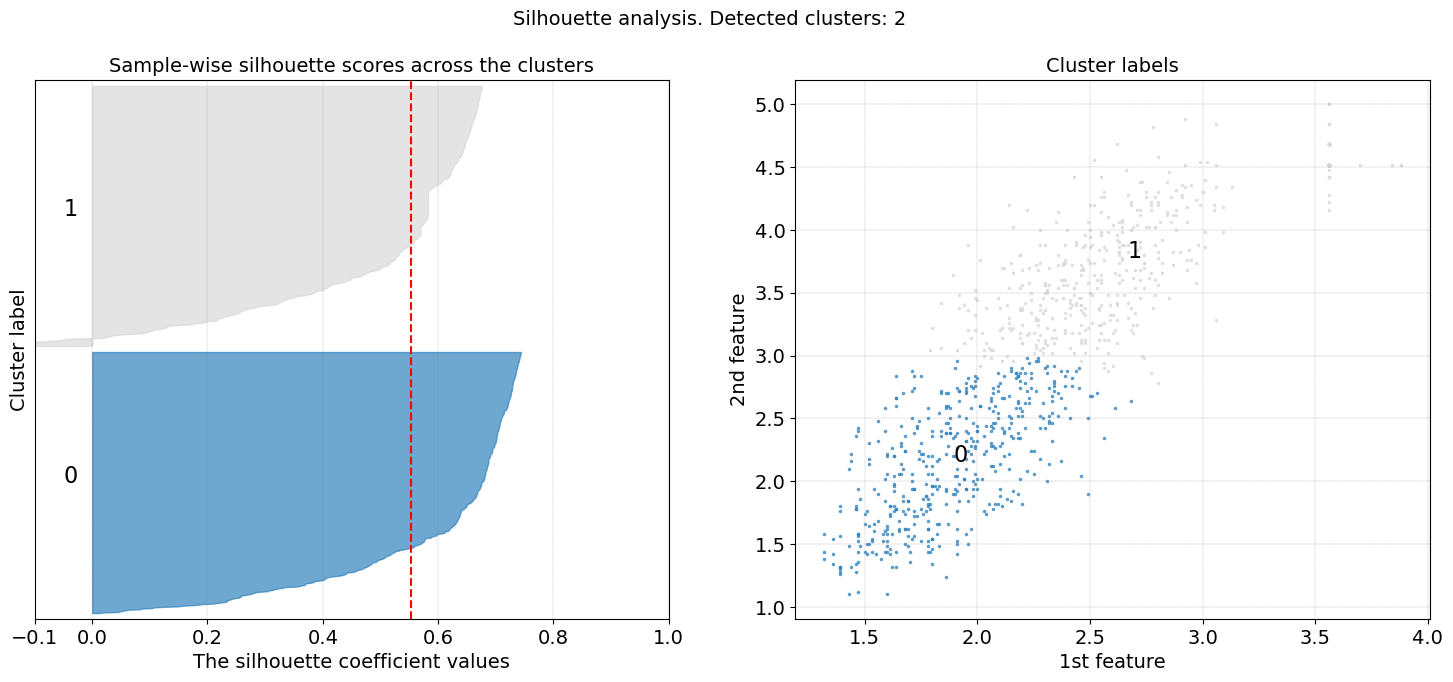

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

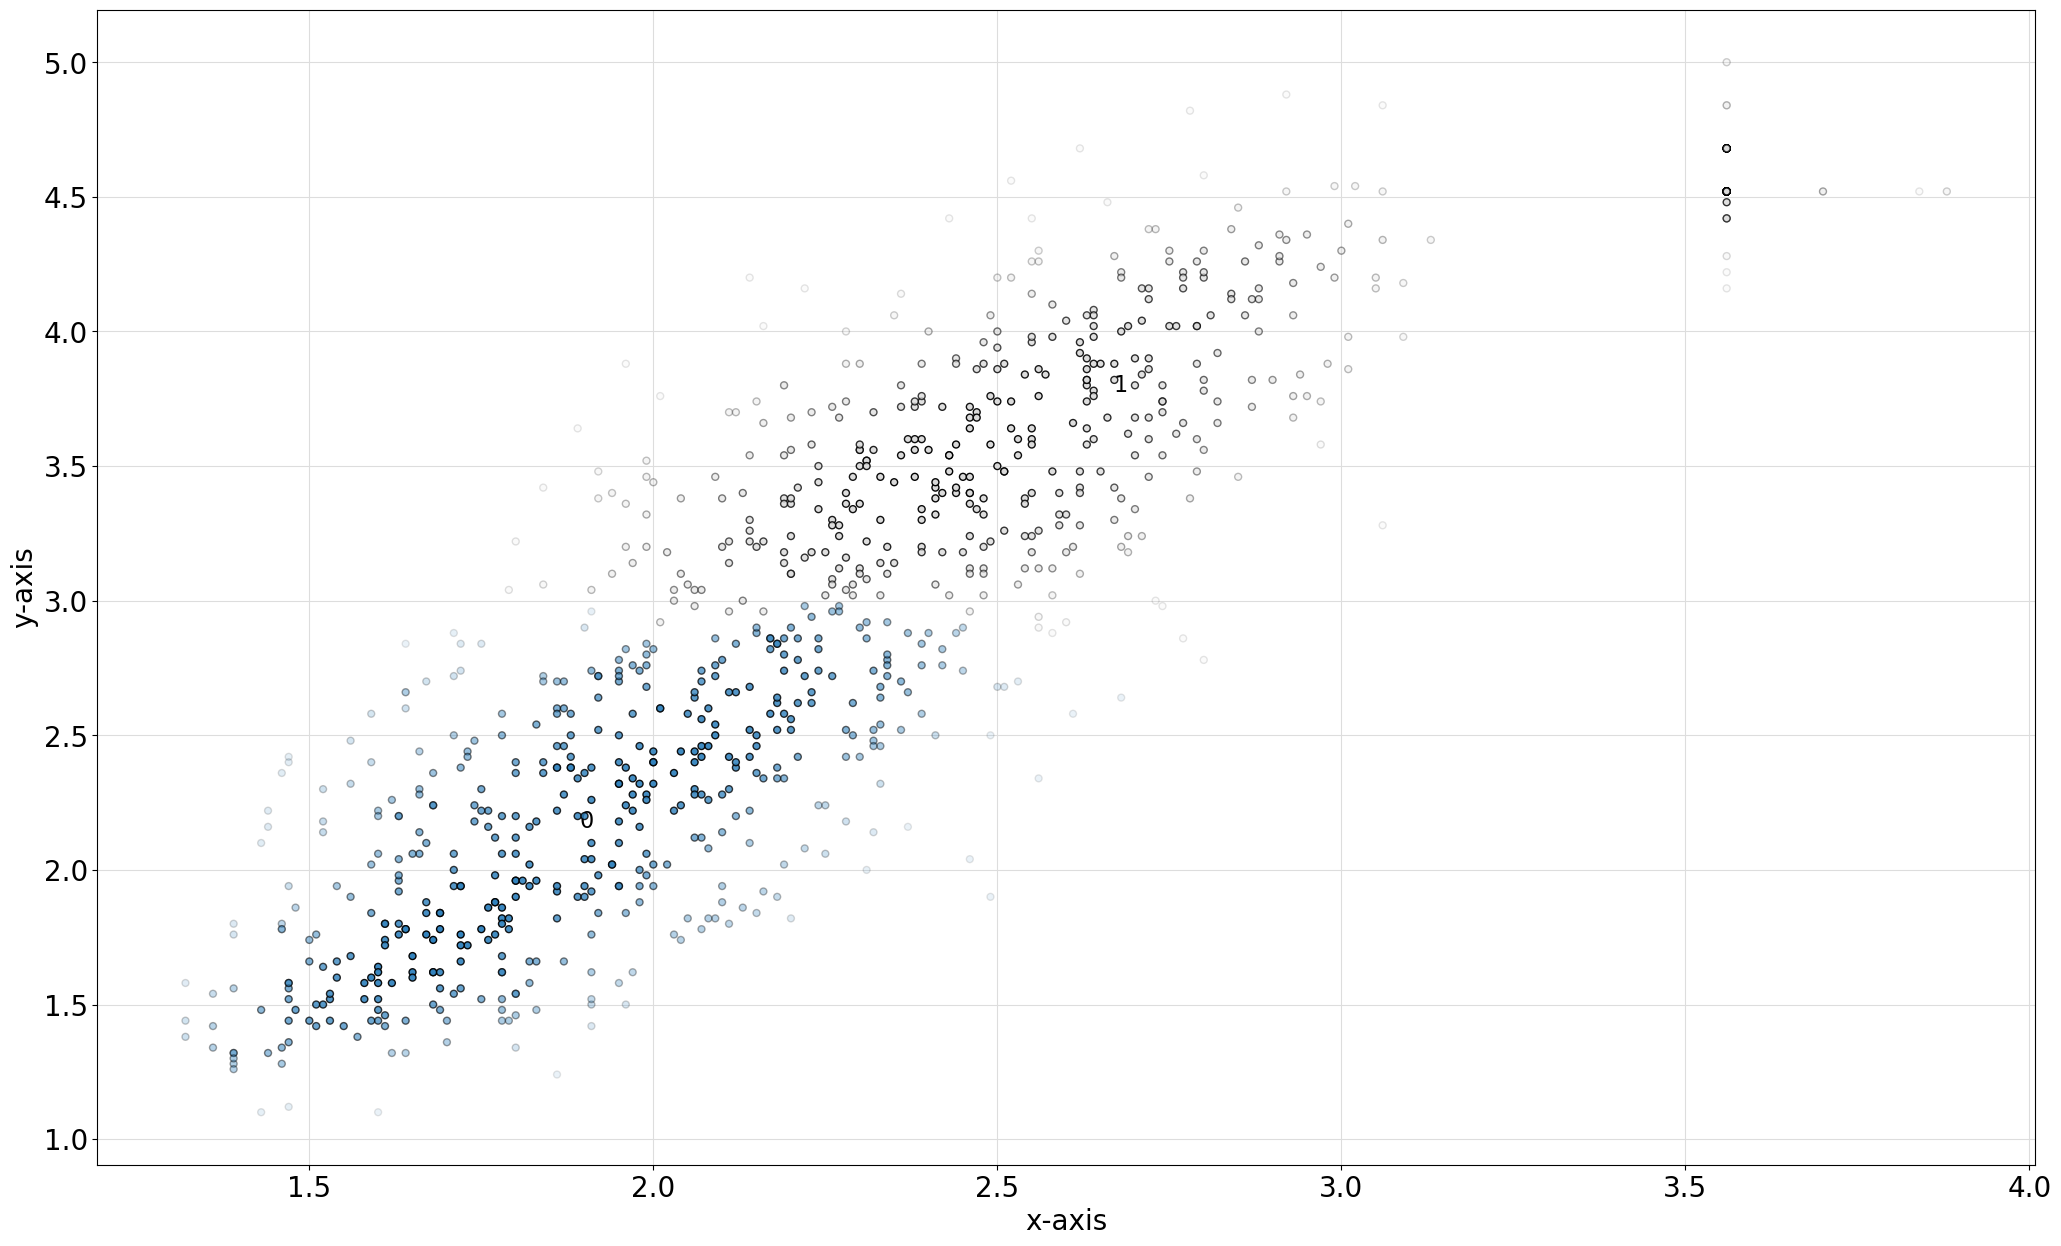

In [13]:
# Intialize model
ce2 = clusteval(cluster='agglomerative', evaluate='silhouette')

# Cluster evaluation
results2 = ce2.fit(X)

# The clustering label can be found in:
print(results2['labx'])

# Make plots
ce2.plot()
ce2.plot_silhouette()
ce2.scatter(X)

#### Parametros con distancia euclidiana y centroides

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[centroid]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 4
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [3].
[clusteval] >INFO> Fin.


[2 2 2 2 2 2 1 2 2 3 2 3 3 3 3 3 2 1 3 1 1 1 3 2 2 2 3 3 3 3 2 3 2 2 3 3 3
 3 1 3 3 2 3 2 3 3 2 3 3 2 3 1 3 2 3 3 3 2 2 2 2 1 2 3 3 3 2 3 2 3 2 2 3 2
 2 1 1 2 2 1 3 3 2 2 2 3 2 3 2 1 2 2 2 2 1 1 1 3 2 3 2 3 3 2 2 2 2 2 2 2 1
 3 3 3 3 2 1 2 3 1 2 3 1 1 2 2 1 2 3 2 3 3 1 1 2 1 2 2 3 3 3 1 1 3 2 3 1 2
 1 3 2 1 3 2 3 3 3 2 3 1 2 3 3 3 2 2 3 2 2 3 3 2 1 2 3 3 2 2 3 1 2 2 2 3 3
 3 3 2 1 1 2 3 2 3 3 3 3 1 2 1 2 3 3 3 1 2 1 2 2 3 3 1 1 3 1 3 2 3 2 3 2 1
 2 2 2 3 1 1 1 3 3 3 2 2 1 2 1 2 2 3 3 3 3 1 2 2 3 3 2 3 1 2 3 2 3 1 2 2 3
 2 3 2 2 1 2 1 2 1 2 3 2 1 1 1 3 3 3 2 2 3 2 2 2 2 1 3 3 3 1 3 3 3 3 3 2 3
 2 2 2 2 2 3 1 2 1 3 2 1 2 3 2 2 3 1 1 1 2 2 3 2 2 1 2 2 2 1 1 1 3 3 3 1 1
 2 1 3 3 3 3 2 3 1 1 3 2 2 1 3 3 3 2 3 3 2 2 3 2 1 3 3 3 2 2 3 3 3 2 2 1 2
 2 1 3 1 2 2 3 2 1 2 3 3 2 3 3 3 3 2 2 1 1 3 3 3 1 2 3 3 3 2 3 2 3 3 1 3 3
 3 2 2 3 2 3 3 3 3 1 3 3 3 2 3 3 3 1 2 2 1 2 1 1 1 2 2 3 3 3 3 3 2 2 3 1 3
 1 3 3 2 2 2 3 2 3 1 3 2 2 3 2 3 2 1 3 2 3 1 3 3 3 3 2 1 3 2 3 1 2 1 2 3 2
 3 2 3 3 2 3 3 3 2 3 3 1 

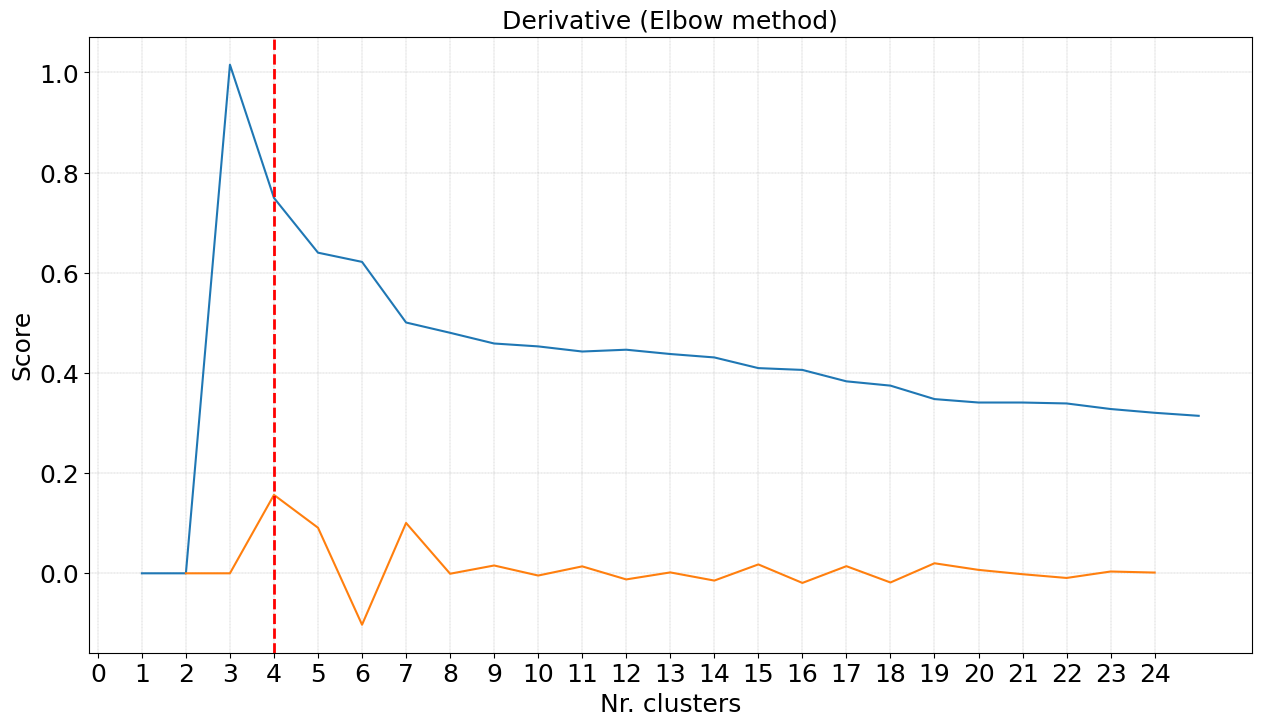

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 3, average silhouette_score=0.444


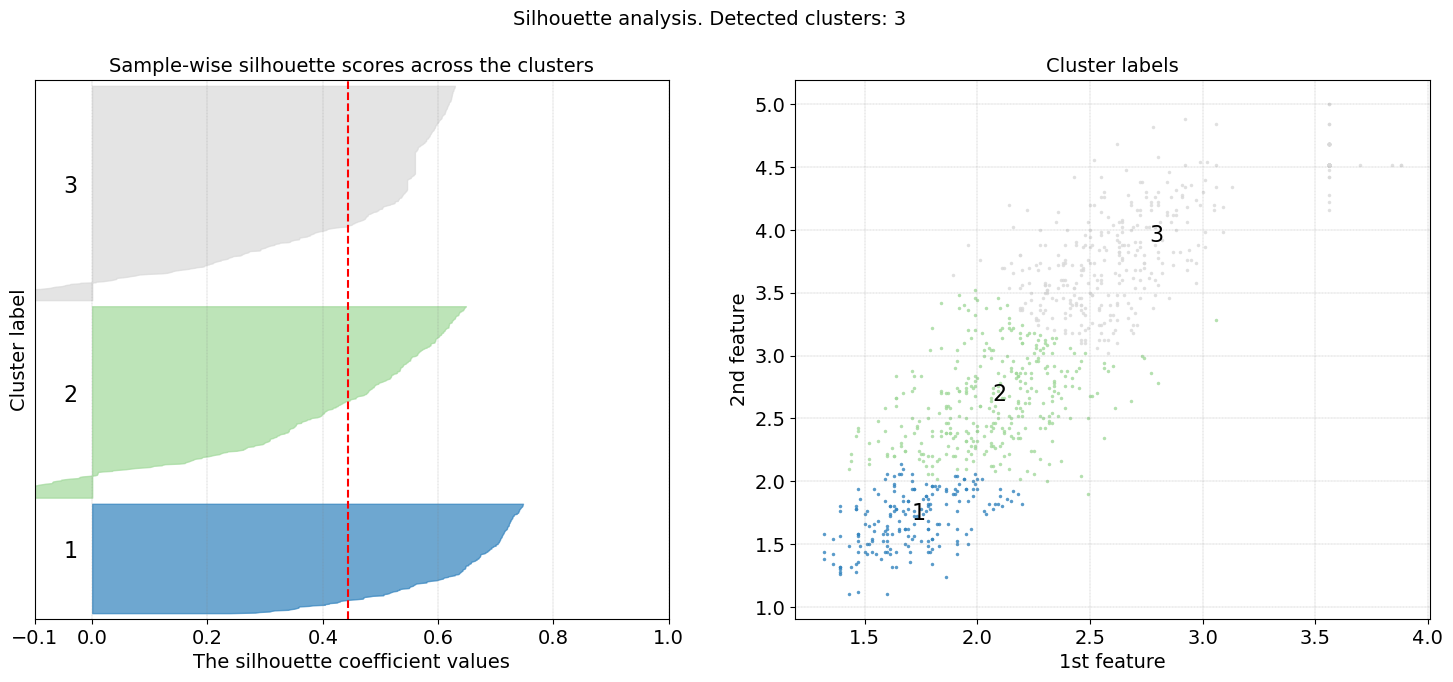

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

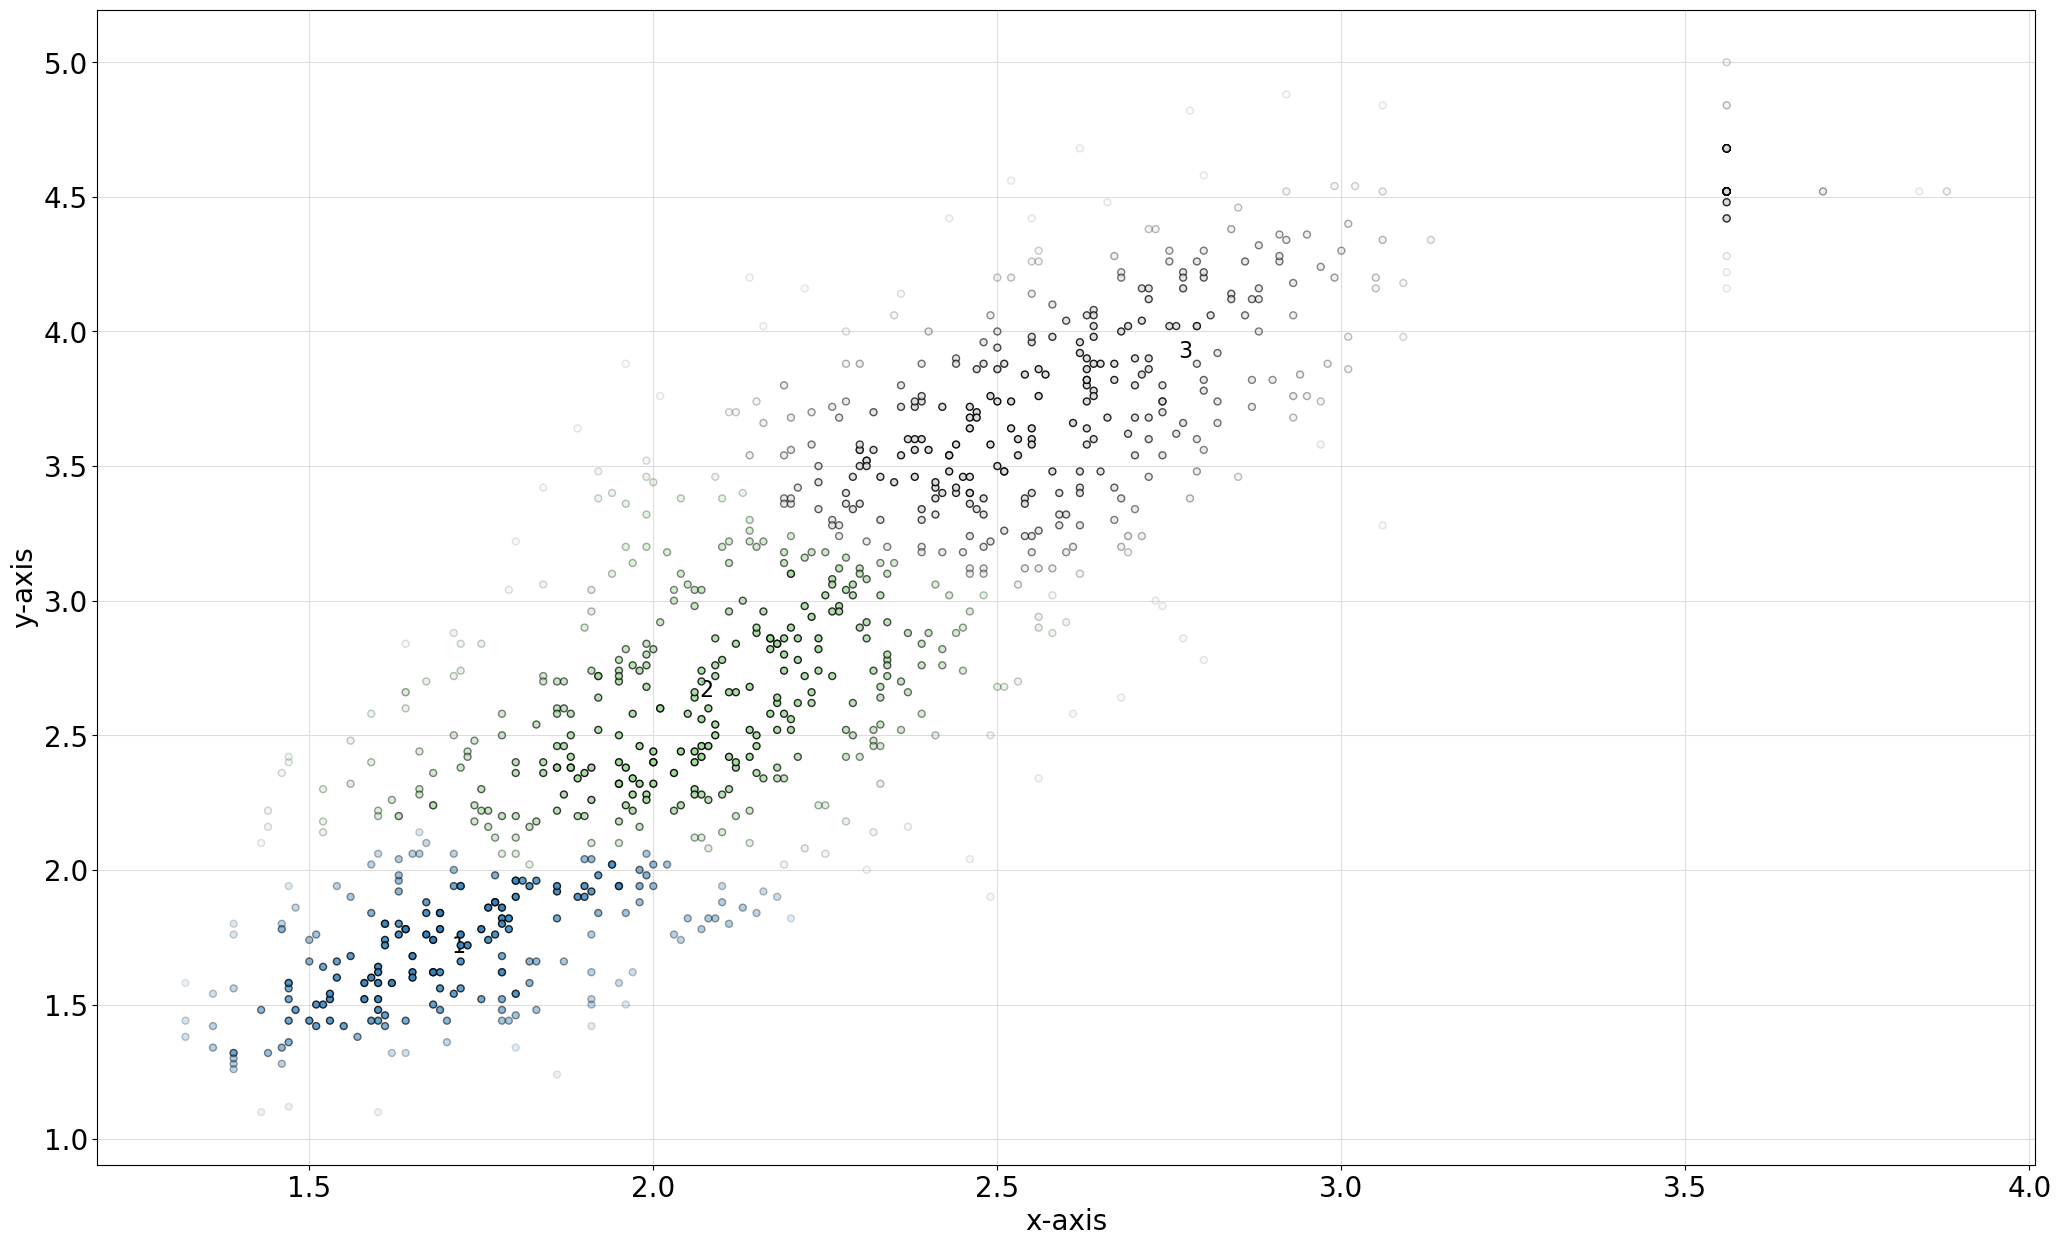

In [14]:
# Intialize model
ce3 = clusteval(cluster='agglomerative', evaluate='derivative', metric='euclidean', linkage='centroid')

# Cluster evaluation
results3 = ce3.fit(X)

# The clustering label can be found in:
print(results3['labx'])

# Make plots
ce3.plot()
ce3.plot_silhouette()
ce3.scatter(X)

#### Parametros con distancia de Jaccard

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[jaccard], linkage=[single]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 15
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [15].
[clusteval] >INFO> Fin.


[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

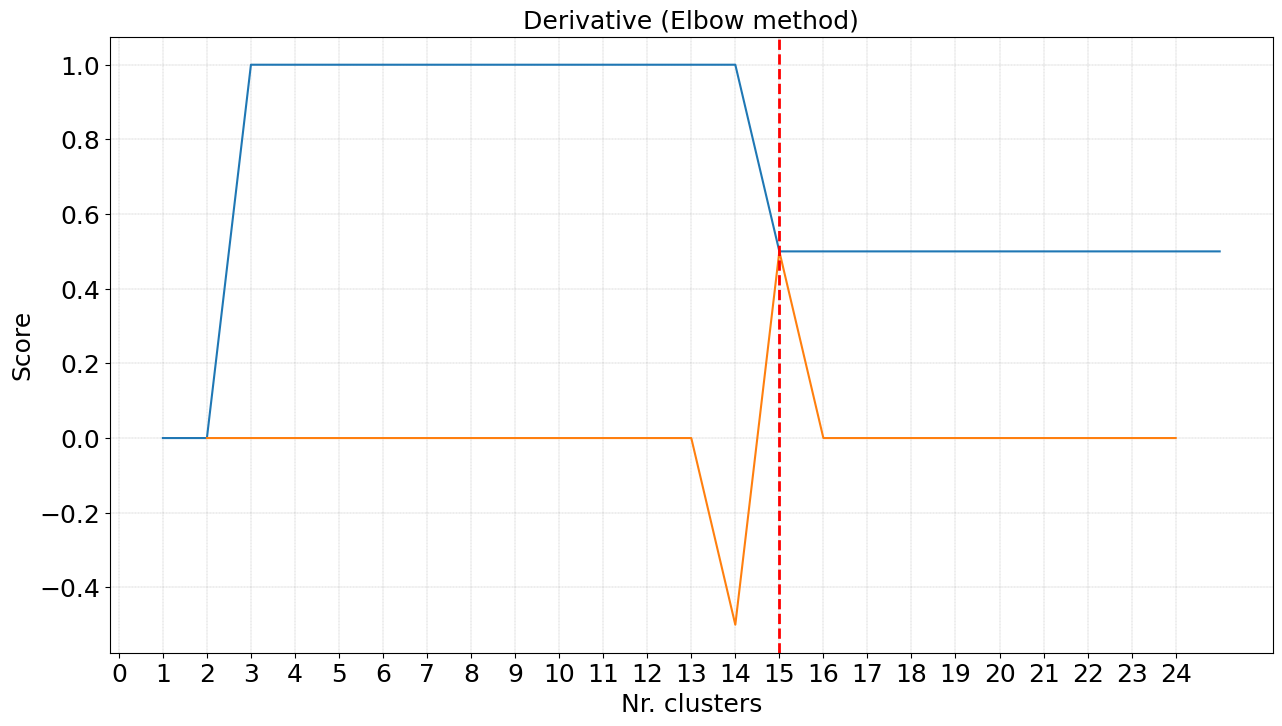

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 15, average silhouette_score=-0.759


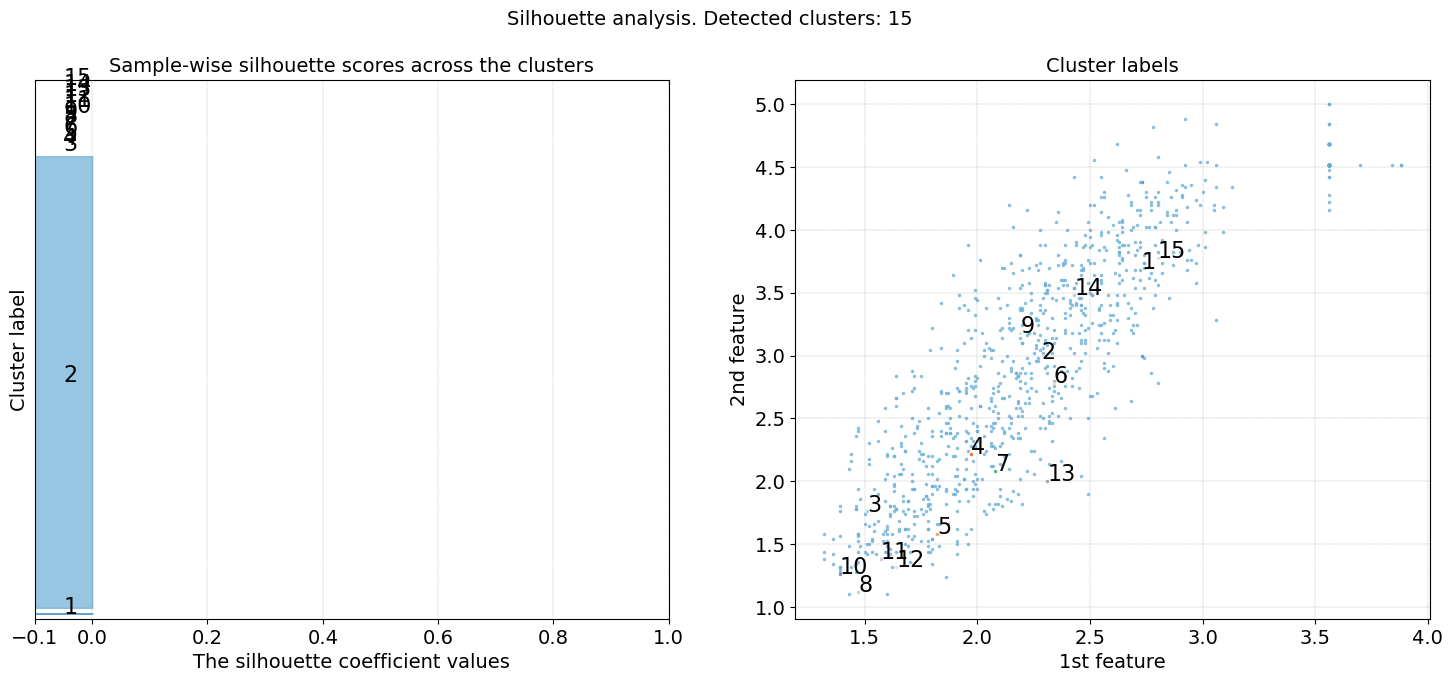

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

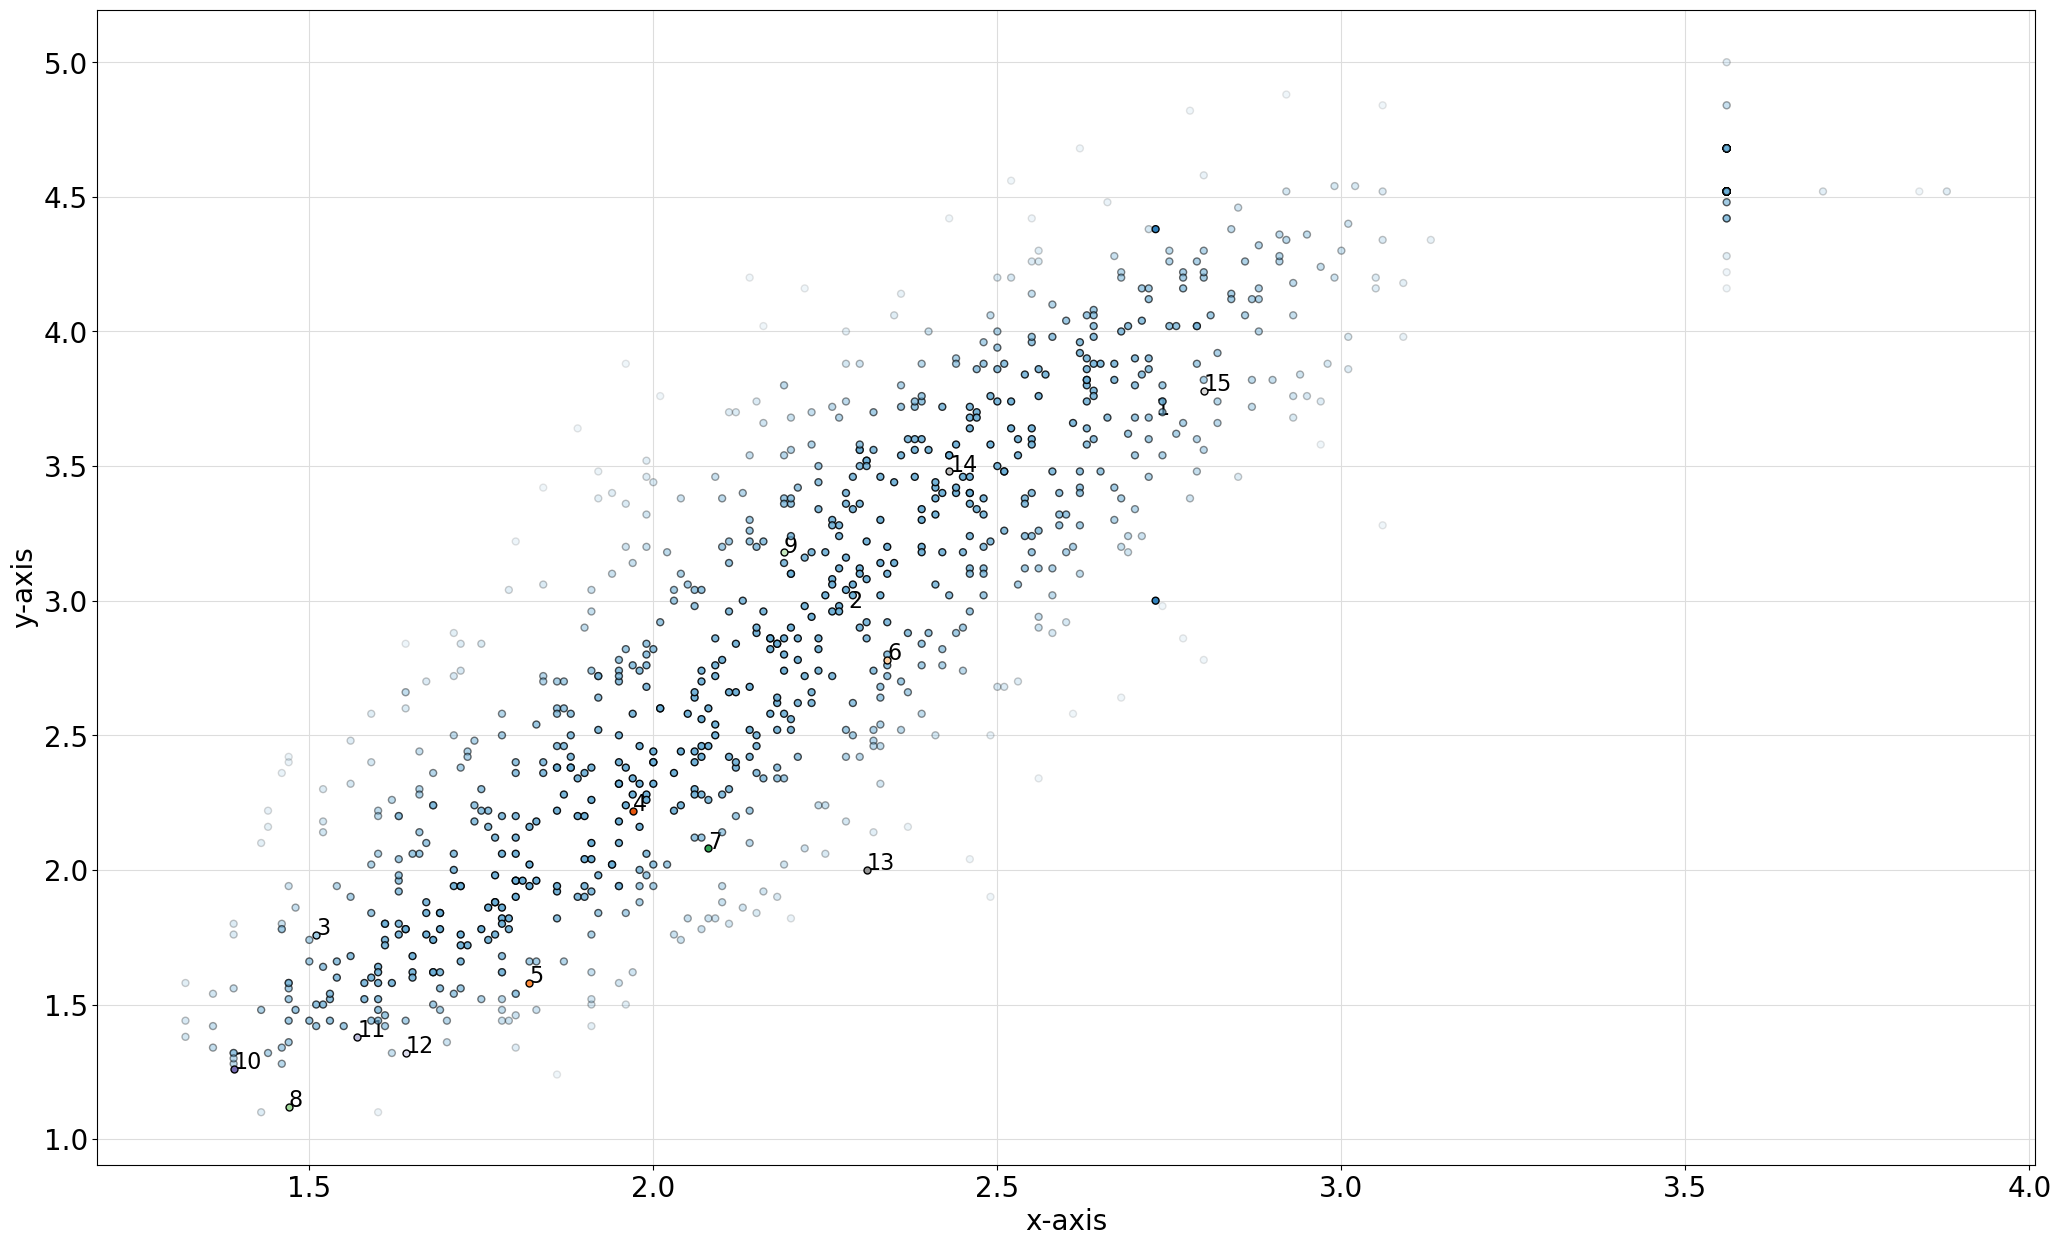

In [15]:
# Intialize model
ce4 = clusteval(cluster='agglomerative', evaluate='derivative', metric='jaccard', linkage='single')

# Cluster evaluation
results4 = ce4.fit(X)

# The clustering label can be found in:
print(results4['labx'])

# Make plots
ce4.plot()
ce4.plot_silhouette()
ce4.scatter(X)

Estimated number of n_clusters: 15, average silhouette_score=-0.759

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[jaccard], linkage=[average]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 16
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [16].
[clusteval] >INFO> Fin.


[ 2  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  1  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1
  2  2  2  2  2  2  2  2  1  2  1  2  2  2  2  2  2  2  2  1  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  1  2  2  2  2  2
  2  2  2  1  1  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  1  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1
  2  1  1  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2  2  1  2  2  2
  2  2  2  4  2  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  1  2  2  2  1  2  2
  2  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  2

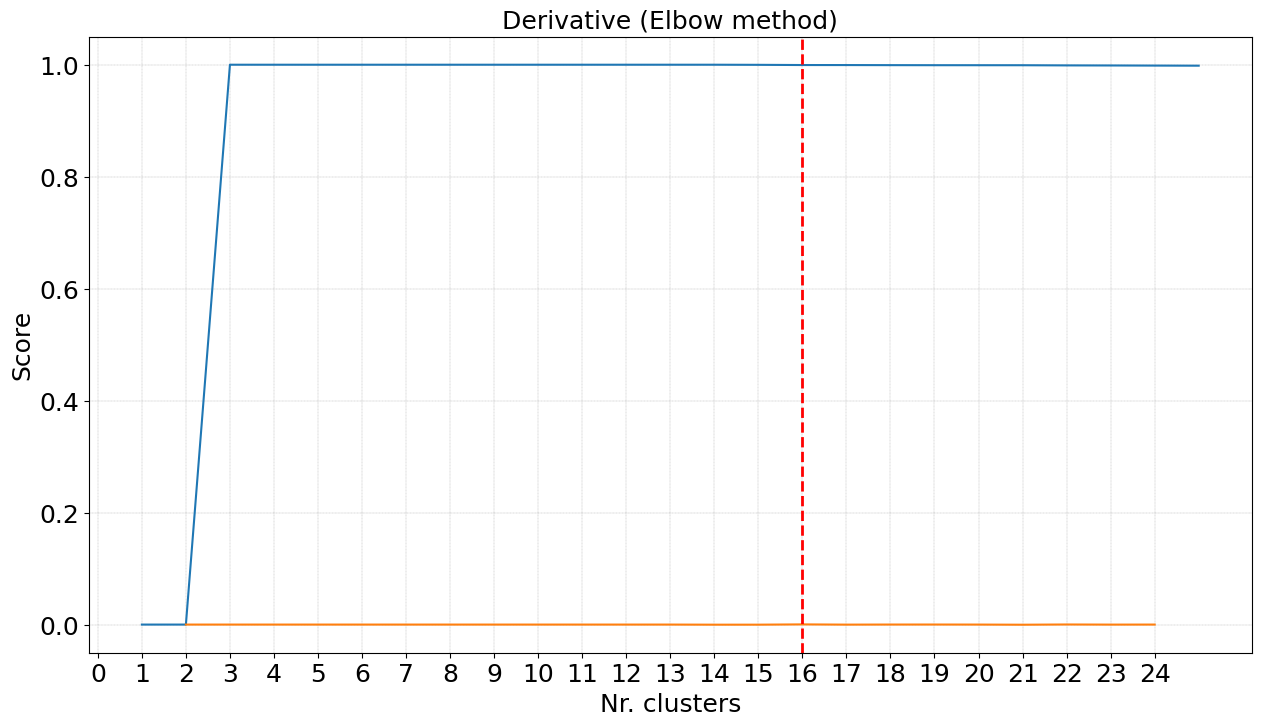

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 16, average silhouette_score=-0.641


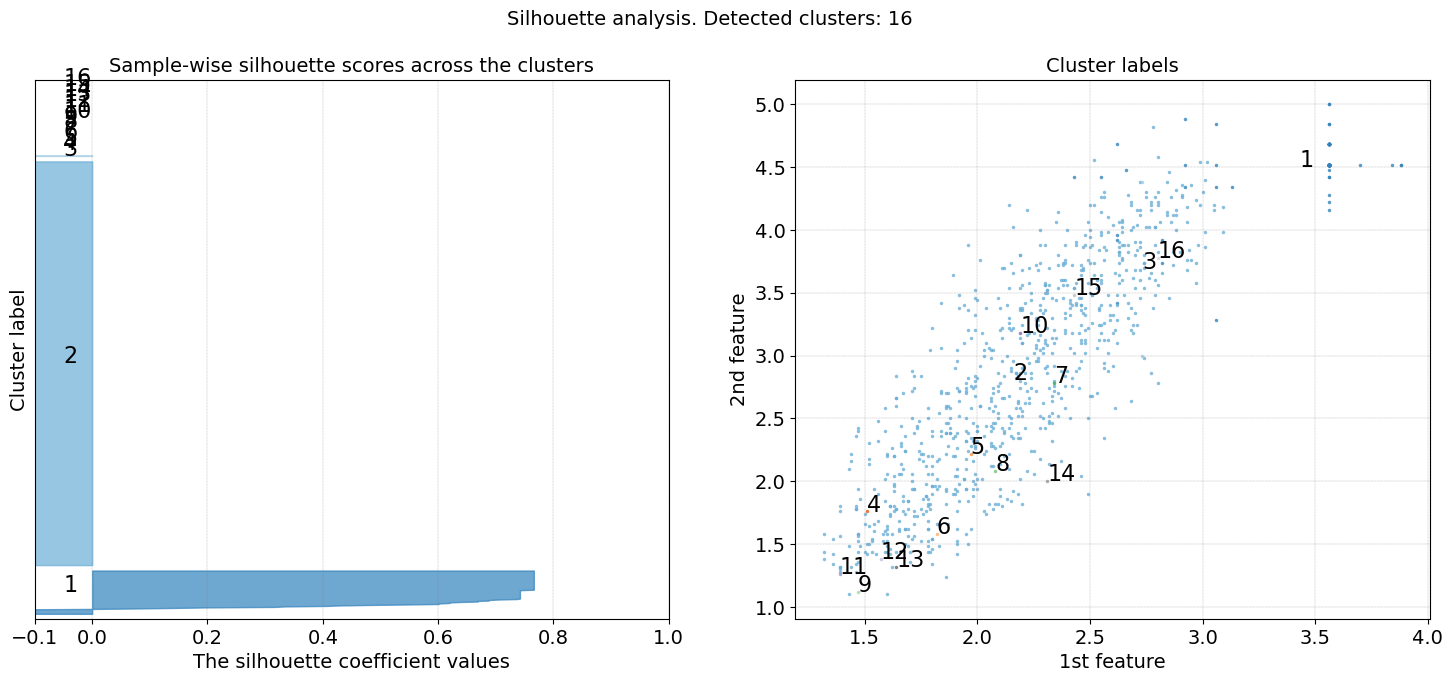

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

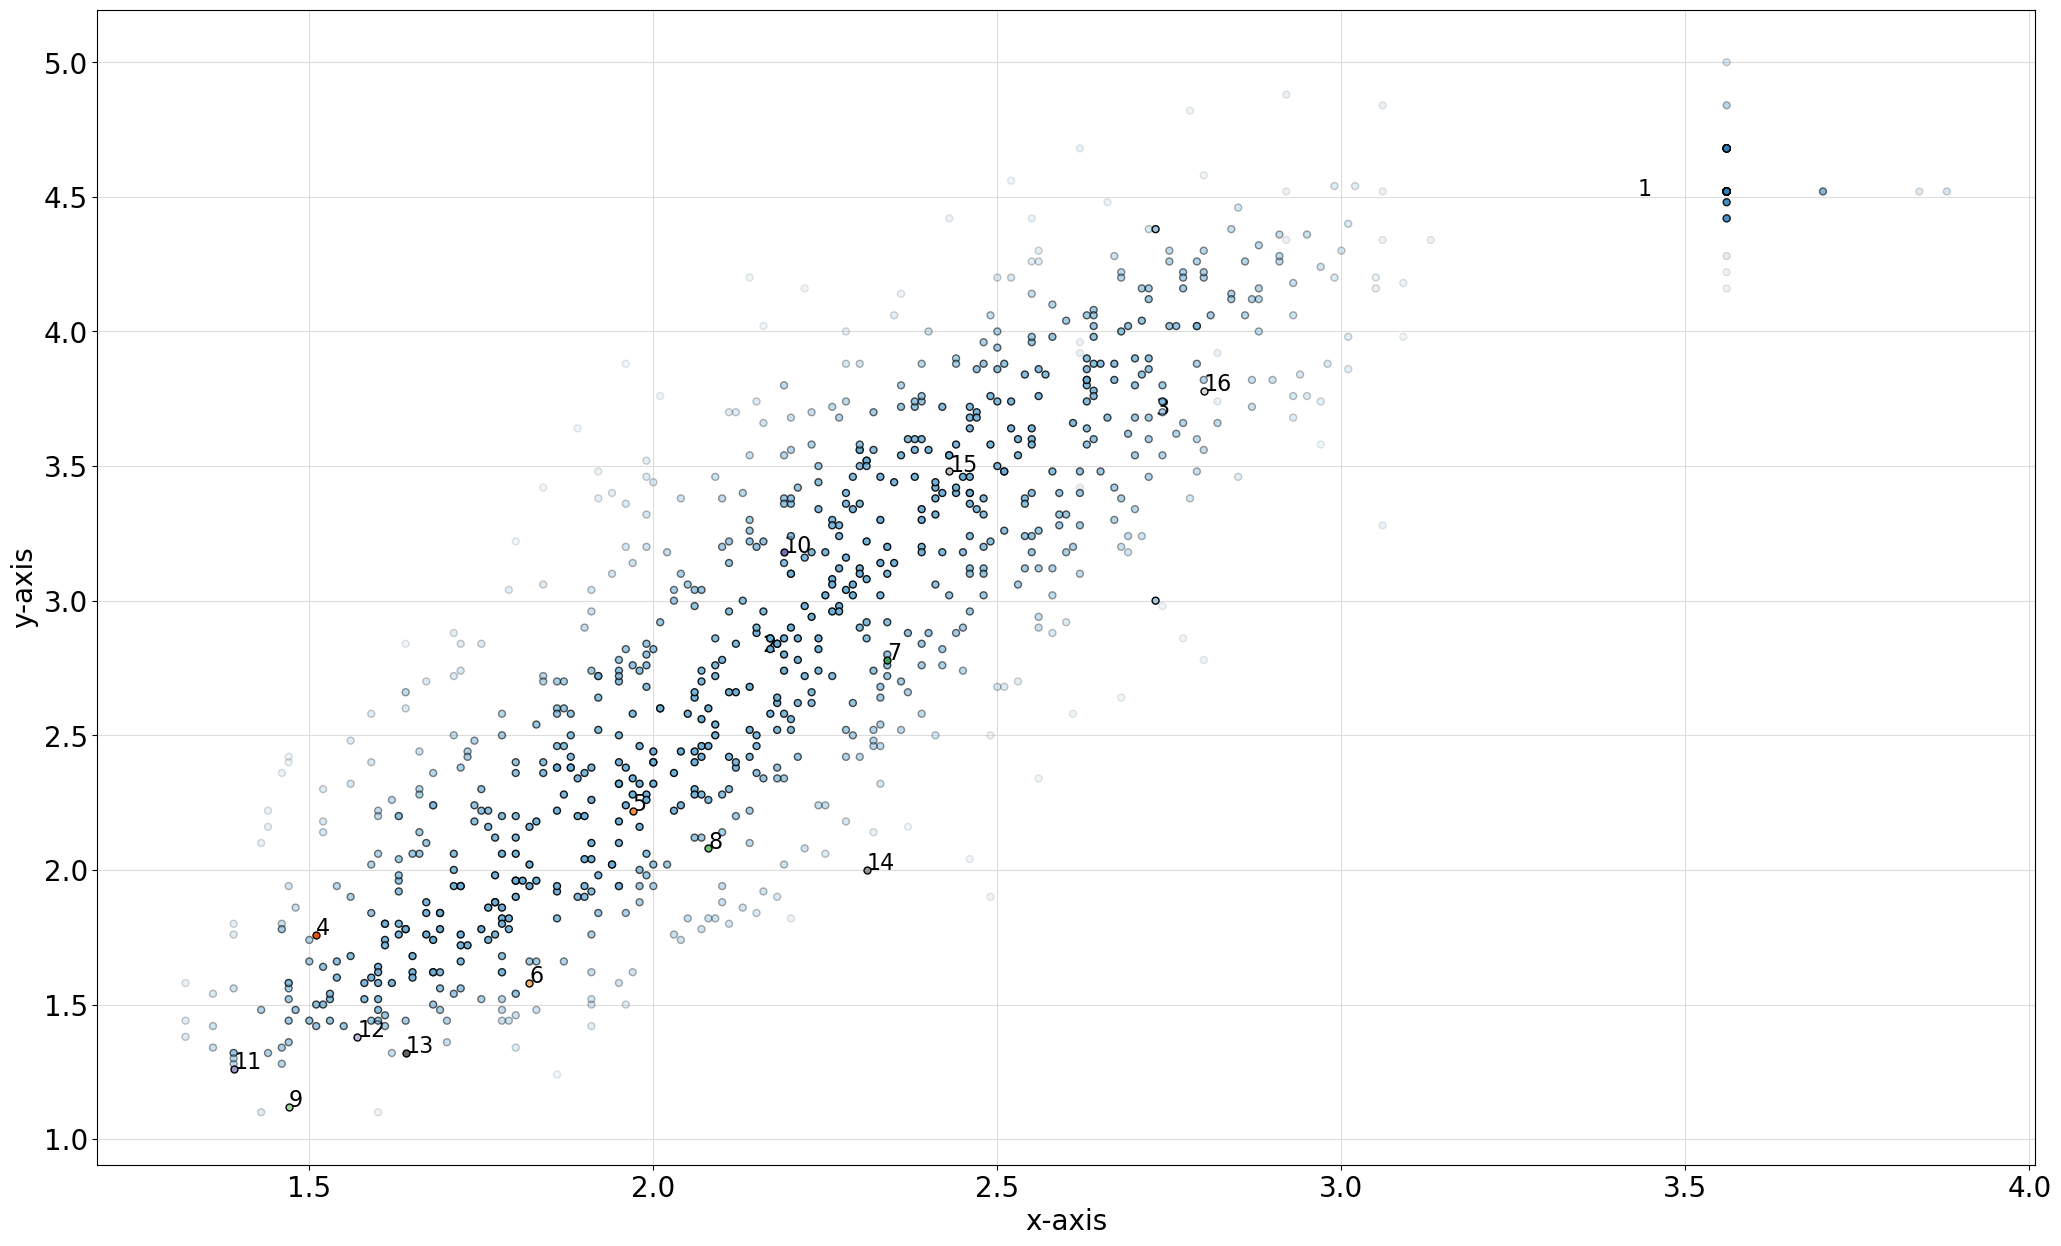

In [16]:
# Intialize model
ce5 = clusteval(cluster='agglomerative', evaluate='derivative', metric='jaccard', linkage='average')

# Cluster evaluation
results5 = ce5.fit(X)

# The clustering label can be found in:
print(results5['labx'])

# Make plots
ce5.plot()
ce5.plot_silhouette()
ce5.scatter(X)

Estimated number of n_clusters: 16, average silhouette_score=-0.641

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[jaccard], linkage=[weighted]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 16
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [16].
[clusteval] >INFO> Fin.


[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  4  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

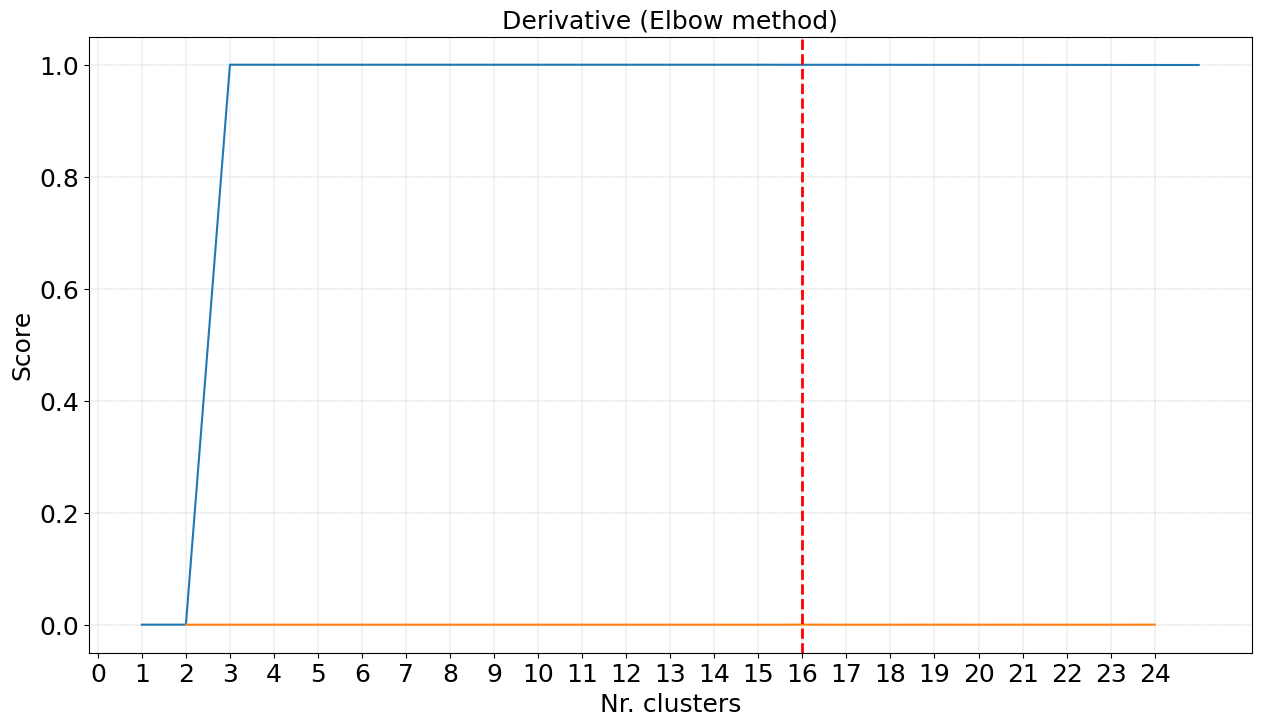

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 16, average silhouette_score=-0.782


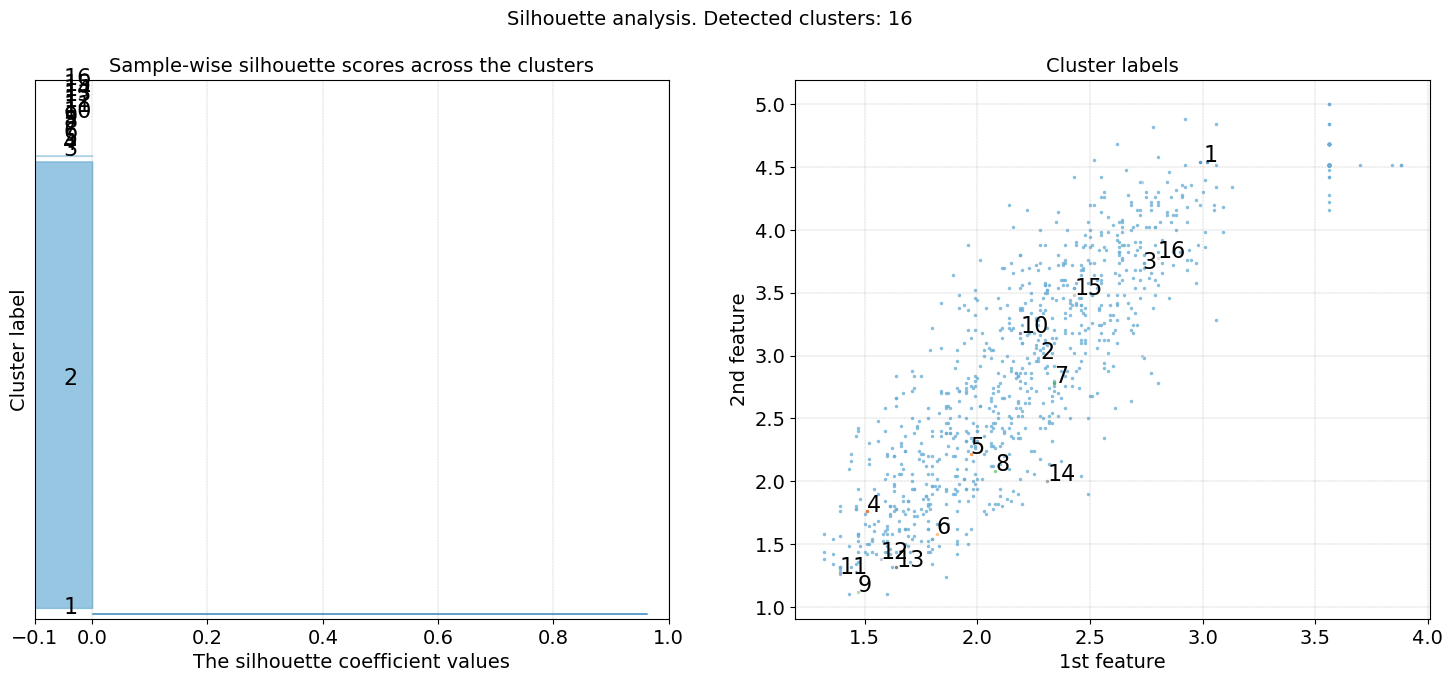

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

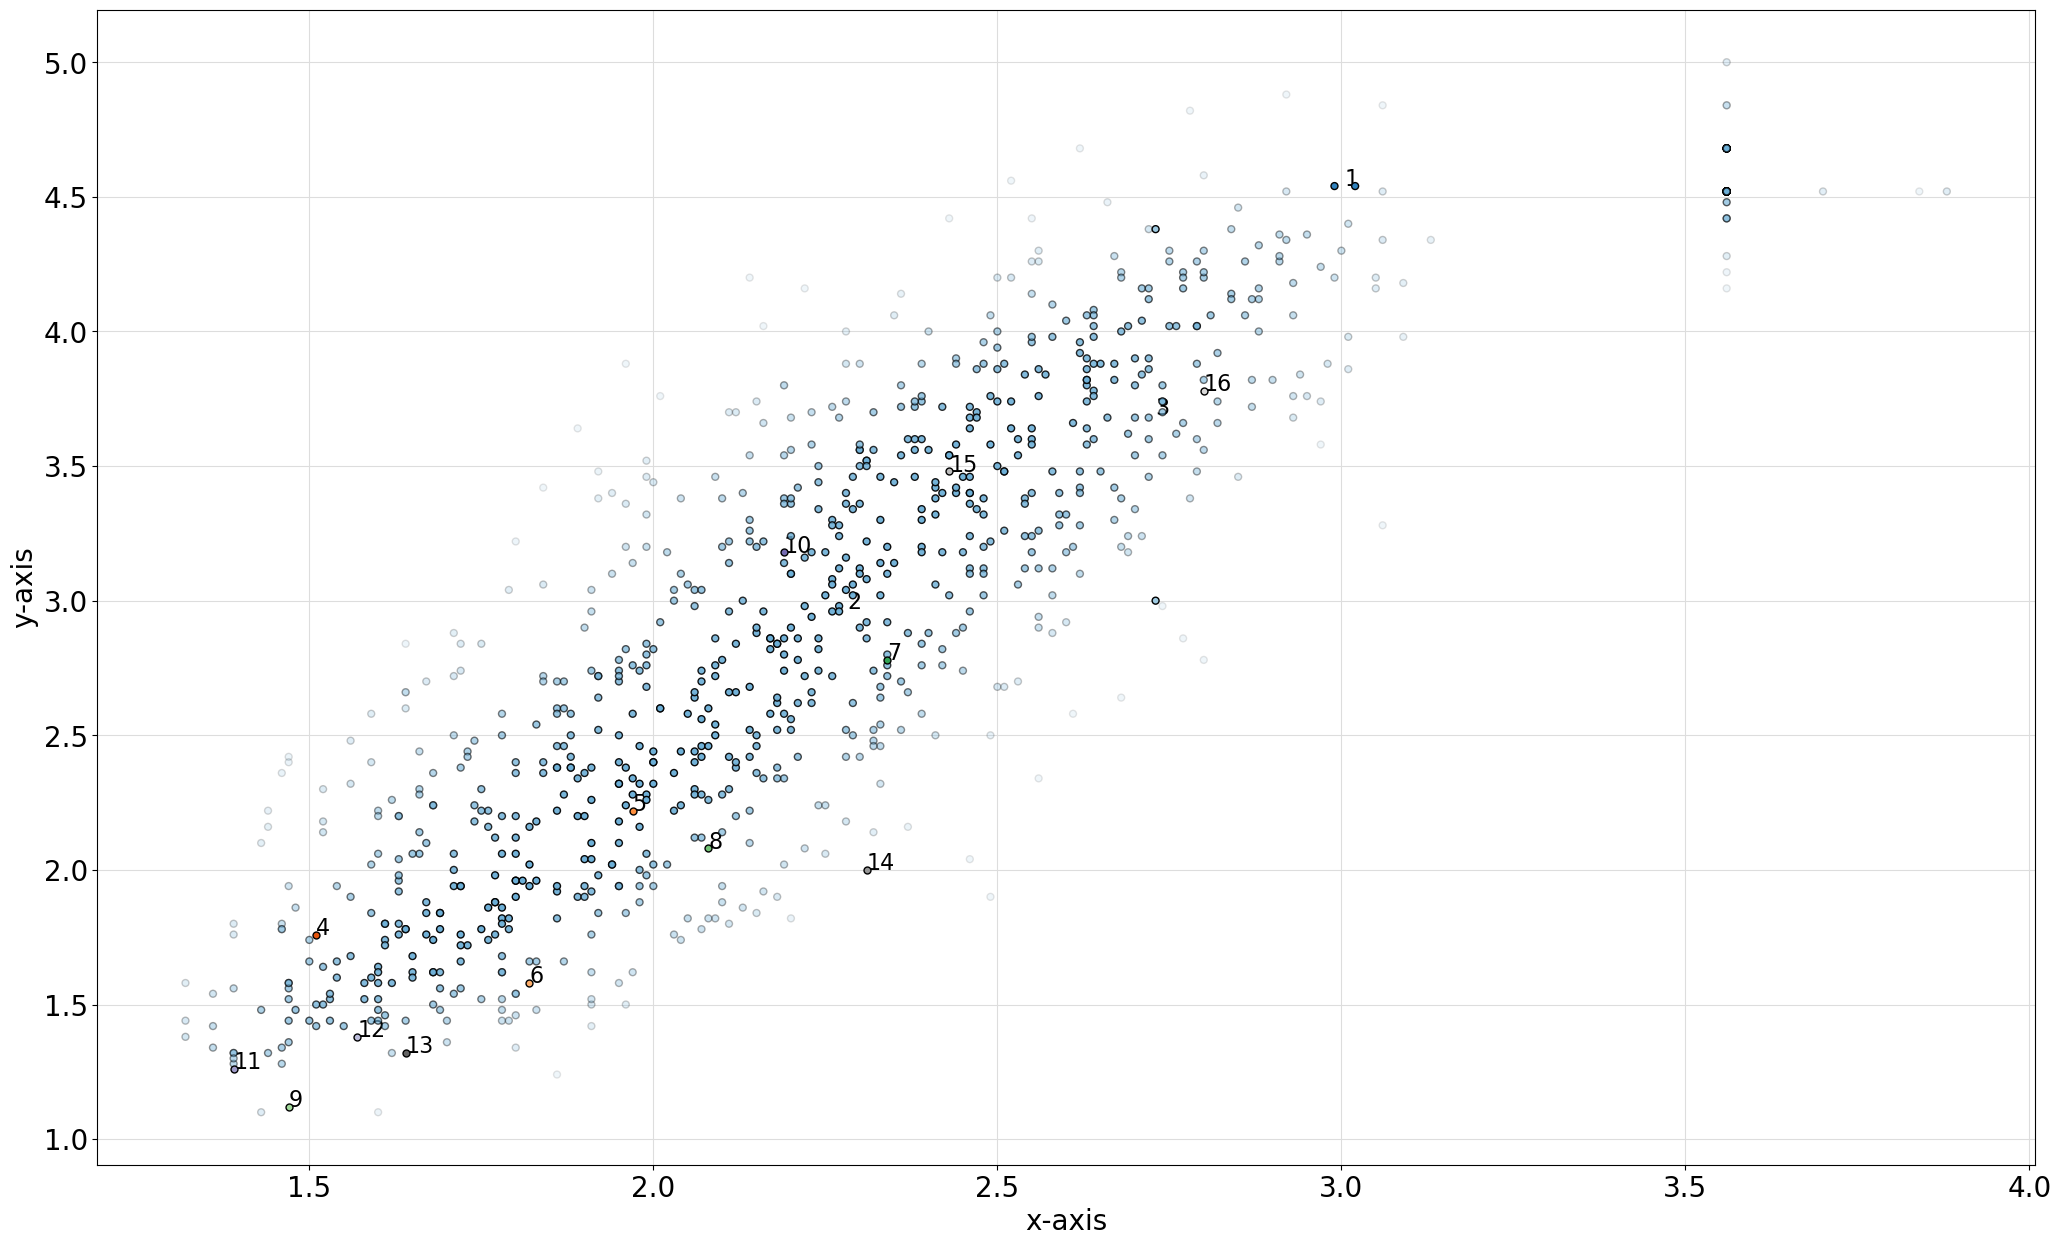

In [17]:
# Intialize model
ce6 = clusteval(cluster='agglomerative', evaluate='derivative', metric='jaccard', linkage='weighted')

# Cluster evaluation
results6 = ce6.fit(X)

# The clustering label can be found in:
print(results6['labx'])

# Make plots
ce6.plot()
ce6.plot_silhouette()
ce6.scatter(X)

Estimated number of n_clusters: 16, average silhouette_score=-0.782

**Mejores parametros**

* modelo 1:
    * cluster='agglomerative', evaluate='derivative' (clusters = 5)
    * Estimated number of n_clusters: 5, average silhouette_score=0.419
* modelo 2:
    * Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
    * Estimated number of n_clusters: 2, average silhouette_score=0.554
* modelo 3:
    * Fit with method=[agglomerative], metric=[euclidean], linkage=[centroid] (clusters = 4)
    * Estimated number of n_clusters: 3, average silhouette_score=0.444

Los modelos basados en distancia de Jaccard no aportan mejores resultados

In [18]:
df['ce1_clusters'] = results1['labx']
df['ce2_clusters'] = results2['labx']
df['ce3_clusters'] = results3['labx']

## Visualizacion

In [19]:
l_hover_data = ['market_position_desc_new', 'relationship_desc_new','qty_2024_score_desc', 'sales_2024_score_desc', 'p2_2024_score_desc',
                'material_portfolio_desc', 'brand_portfolio_desc', 'product_type_portfolio_desc', 'feature_tag_null_score', 'feature_tag_q1_score',
                'feature_tag_q2_score', 'feature_tag_q3_score', 'feature_tag_q4_score']

In [20]:
px.scatter(df,
           x = 'current_business',
           y = 'potential',
           color = 'ce1_clusters',
           hover_name= 'customer',
           hover_data = l_hover_data,
           title = 'Clustering modelo ce1')

In [21]:
px.scatter(df,
           x = 'current_business',
           y = 'potential',
           color = 'ce2_clusters',
           hover_name= 'customer',
           hover_data = l_hover_data,
           title = 'Clustering modelo ce2')

In [22]:
px.scatter(df,
           x = 'current_business',
           y = 'potential',
           color = 'ce3_clusters',
           hover_name= 'customer',
           hover_data = l_hover_data,
           title = 'Clustering modelo ce3')

El modelo ce3 muestra una mejor segmentacion para toma de decisiones:
* cluster 1 = customers que aportan poco valor, tienen bajo nivel de relacion con la empresa y portafolio pequeño
* cluster 2 = customers con potencial de crecimiento, portafolio mas grande y representan un mayor volumen de ventas
* cluster 3 = customers con gran potencial de crecimiento e innovacion, portafolios mas amplios y mayor volumen de ventas

## Key Account figures

In [23]:
# une key_account de uno de los datasets anteriores a df
df = pd.merge(df, df_numdata[['customer', 'key_account']], how= 'inner', on='customer')

In [25]:
# agrega dato de cluster del modelo ce3 a datos categoricos
df_catdata = pd.merge(df_catdata, df[['customer', 'ce3_clusters']], how='inner', on='customer')
df_catdata.head(2)

plant   plant_types sourcing_vendor   material      brand  \
0  Plant_421  Plant_Type_2      Vendor_993  MAT001622  Brand_353   
1  Plant_421  Plant_Type_2      Vendor_993  MAT001622  Brand_353   

      sub_brand      product_type        product_subtype window_tag  \
0  Sub_Brand_18  Product_Type_321  Product_SubType_321-3       Null   
1  Sub_Brand_18  Product_Type_321  Product_SubType_321-3       Null   

        customer    ship_to_customer      key_account key_account_grouper  \
0  Customer_5922  ShipToCustomer_804  Key_Account_184           Region_23   
1  Customer_5922  ShipToCustomer_804  Key_Account_184           Region_23   

     country  ce3_clusters  
0  Country_3             3  
1  Country_3             3

In [26]:
# lista de key_accounts con customers en cluster 3
l_ka_cl3 = [k for k in df[df_catdata['ce3_clusters']==3]['key_account'].unique()]

C:\Users\fefys\AppData\Local\Temp\ipykernel_12160\3504629192.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [27]:
# elije un key_account desde los indices (max 339)
key_account = l_ka_cl3[2]

In [28]:
# prospecto y sus customers
print(key_account)
for c in [i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()]:
    print(f"customer {c}\t type: {df[df['customer']==c]['ce3_clusters'].unique()}\t relationship: {df[df['customer']==c]['relationship_desc_new'].unique()}\t mkt_pos: {df[df['customer']==c]['market_position_desc_new'].unique()}\t country: {df_catdata[df_catdata['customer']==c]['country'].unique()}")

Key_Account_110
customer Customer_2875	 type: [3]	 relationship: ['Advanced Business Ties']	 mkt_pos: ['Innovative & Faster Growing than Market']	 country: ['Country_6']
customer Customer_1023	 type: [2]	 relationship: ['Pure Business']	 mkt_pos: ['Niche Player']	 country: ['Country_4']
customer Customer_2064	 type: [1]	 relationship: ['Transactional']	 mkt_pos: ['Niche Player']	 country: ['Country_3']


In [29]:
# feature tags por customers de un key account (prospecto)
px.histogram(df_catdata[df_catdata['key_account']==key_account],
             x = 'window_tag',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             template = 'plotly_dark',
             title = f"{key_account}: feature tags per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [30]:
px.bar(df_catdata[df_catdata['key_account']==key_account],
             x = 'plant',
             color = 'ce3_clusters',
             hover_name='customer',
             hover_data= ['plant_types'],
             barmode='group',
             template = 'plotly_dark',
             title = f"{key_account}: sourcing plants per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [31]:
px.histogram(df_catdata[df_catdata['key_account']==key_account].sort_values('plant_types', ascending=True),
             x = 'plant_types',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             template= 'plotly_dark',
             title = f"{key_account}: plant types per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [32]:
px.histogram(df_catdata[df_catdata['key_account']==key_account].sort_values('plant_types', ascending=True),
             x = 'sourcing_vendor',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             template= 'plotly_dark',
             title = f"{key_account}: sourcing_vendors per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [33]:
px.bar(df_catdata[df_catdata['key_account']==key_account].sort_values('material', ascending=True),
             x = 'material',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             hover_data= ['brand','sub_brand', 'product_type', 'product_subtype', 'plant', 'sourcing_vendor'],
             template= 'plotly_dark',
             title = f"{key_account}: materials(with brands and products) per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [34]:
px.bar(df_catdata[df_catdata['key_account']==key_account].sort_values('product_subtype', ascending=True),
             x = 'product_subtype',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             hover_name = 'product_type',
             hover_data= ['brand','sub_brand', 'product_type', 'product_subtype', 'plant', 'sourcing_vendor'],
             template= 'plotly_dark',
             title = f"{key_account}: product types and subtypes per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )

In [35]:
px.bar(df_catdata[df_catdata['key_account']==key_account].sort_values('sub_brand', ascending=True),
             x = 'sub_brand',
             color = 'ce3_clusters',
             facet_col='customer',
             barmode='group',
             hover_name = 'brand',
             hover_data= ['brand','sub_brand', 'product_type', 'product_subtype', 'plant', 'sourcing_vendor'],
             template= 'plotly_dark',
             title = f"{key_account}: product types and subtypes per customers ({', '.join([i for i in df_catdata[df_catdata['key_account']==key_account]['customer'].unique()])})"
             )